In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import datetime
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_orig= pd.read_csv("https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$limit=999999999&$where=created_date%20between%20%272019-01-01T00:00:00.000%27%20and%20%272020-01-01T00:00:00.000%27")   




/Users/bwitte/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (8,17,31,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
type(data_orig.created_date)

pandas.core.series.Series

In [109]:
db = data_orig

In [110]:
#convert created and closed date columns to datetime, create new column called response time
db['created_date'] = pd.to_datetime(db['created_date'],errors = 'coerce')
db['closed_date'] = pd.to_datetime(db['closed_date'],errors = 'coerce')
db['response_time'] = db['closed_date'] - db['created_date']

In [111]:
#make all timedelta series into floats of total hours, remove all rows with NaN response_time
db['response_time_days'] = [i.total_seconds()/86400.0 for i in db['response_time']]
db['response_time_hours'] = [i.total_seconds()/3600.0 for i in db['response_time']]
db['response_time_minutes'] = [i.total_seconds()/60.0 for i in db['response_time']]
db['response_time_seconds'] = [i.total_seconds() for i in db['response_time']] 
db = db[db['response_time'].notnull()]

In [112]:
#create a new binary column reflecting whether a complaint took fewer than 2 minutes to resolve
def less_than(time):
    if time <= 120.0:
        return 1
    else:
        return 0

db['under_120'] = list(map(lambda x: less_than(x), db['response_time_seconds'])) 

/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [113]:
#remove rows without a resolution description, make all resolution descriptions lower
db['resolution_description']= db['resolution_description'].replace(np.nan, 'unknown', regex=True)
db['resolution_description'] = db['resolution_description'].str.lower()

/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [114]:
db[db.res_desc == "string"].resolution_description.value_counts()

AttributeError: 'DataFrame' object has no attribute 'res_desc'

In [115]:
#create a categorical column that provides a summarized description of the resolution description - used to group
#and analyze resolution descriptions

dno = ['did not observe', 'not able to gain access','could not find the problem', 'were gone','found no condition'\
      , 'no indication', 'no evidence', 'not find', 'unable to gain entry','no graffiti was found', 'could not locate',\
      'unable to find','attempted to investigate this complaint', "unable to identify", "you did not provide enough information",\
      "observed no evid", "inspected the location for the condition you reported and could not"]

no_action_taken = ['determined that no further action was necessary','condition meets its standards',\
                  'no sewer back up', 'at this time', 'no action', 'not necessary','had been restored',\
                  'found it to be a temporary','inspected the location more than six months ago',\
                  'conflicts with surrounding infrastructure','did not have enough information',\
                  'an inside condition','closed or canceled this complaint','insufficient information',\
                  'does not meet the criteria','no further action is required','did not have sufficient information',\
'no work order was necessary','did not meet the criteria','unable to schedule a sidewalk', 'no violation',\
                  'not have sufficient', 'ineligible', 'was cancelled', 'in compliance with standards', 'was in compliance',\
                  'not enough information', "is not a violation", "confirm the details of your complaint", "you are still responsible",\
                  "could not be serviced", "requested location cannot", "no work is nece", "does not violate any law or rule"]

under_review_wait = ['will review your complaint',' will contact you', 'asked the department of', 'further investigation is required',\
                    'timeframe for repair work depends','has been scheduled', 'will inspect', \
                    'will contact you','a report was prepared','complaint conditions are still open',\
                    'will perform work to correct the condition','has sent official written','please check back later for status',\
                    'and will visit the location','will investigate the issue','usually requires 7 days to inspect',\
                    'usually requires 30 days to inspect','referred this complaint','a location of concern',
                    'your report has been sent','has received and processed your complaint','the literature will be emailed',\
                    'will review this service request','in the process of investigating','scheduled an inspection',\
                    'garage or bureau for further action','will investigate the issue','approved the sidewalk re-inspection request',\
'usually requires 10 days to review a request','will clean the graffiti','has been forwarded',\
'please note your service request number for future reference','requires contact with the complainant','will be notified',\
'will investigate','will fulfill','will receive','an inspection is warranted','to respond to this type of complaint',\
'to evaluate this type of request','opened a repair order','will be planned','long term and vary','will  investigate', \
                     'temporarily', 'partially rectified', 'will review','will notify','has been filed', \
                     'further investigation','will note','under investigation','mailed you a complaint form', "requires you to attend a hearing",\
                    "please submit the following document", "will be scheduled", "will take place within 35 days", "the timeframe for repair",\
                    'they needed to confirm']

violations = ['violations were issued', 'board violation', 'notice of violation','stop work order violation(s) issued', 'violation was issued']

fixed = ['repaired the problem','department of sanitation removed the items','corrected the','correct the', 'repaired',\
         'cleaned', 'addressed the issue','provided the assistance','removed the graffiti','will be addressed',\
         'offered services', 'conditions were corrected','shut the running hydrant', 'were corrected', 'you will receive',\
        'collected', 'resolved', 'researched this complaint', 'took action','issued a','the problem was fixed',\
        'work was performed','removed the stop work order','the literature has been mailed',\
        'complaint was not warranted','performed repair work','made a repair','outreach assistance was offered',\
'opened fire hydrants','picked up the items','if the condition returns','salted the area','updated its records',\
'to a hospital','has been completed', 'was addressed','owner refused', 'debris was obstructing', 'was mailed','have mailed',\
        'was placed','created a service request','created a service request','mailed the requested item',\
         'investigated this complaint and','sent a report', "pled guilty", "a hearing was scheduled", "temporary repairs were made",\
        "has planted the tree", "the letter was returned as undeliverable", "plowed the area.", "made an arrest", "a summons has been issued"]

ambiguous = ['see notes', 'find additional information', 'learn more','more information', \
             'researched your claim','asked the department',\
            'has notified the property owner','additional information below', 'violations were previously issued',\
             'currently not available','unknown', "the department of buildings reviewed this complaint and closed it. if the problem still exists,",\
            "a defect was found done", "surcharge conditions have been confirmed",\
             "the department of transportation inspected the condition you reported. you can find additional infor",\
            "reviewed this complaint and closed it. if the problem still exists", "and found that the condition m",\
            "a representative from the taxi and limousine commission (tlc) called and left a message for you and",\
            "due to technical issues or other circumstances", "inspected the condition and made the determination that the street",\
            "inspected the condition you reported and determined that this issue"]

wrong_agency = ['jurisdiction', 'referred it','referred it to', "has referred this request",\
                "handling by an alternate entity", "the department of transportation inspected and has requested the department of environmental protect"]

dup = ['duplicate','previously reported by another','an open service request already exists', 'received an earlier complaint about the same location']

def string_replace(string):
    if string == 'unknown':
        return string
    elif any(x in string for x in no_action_taken):
        return 'no_action_taken'
    elif any(x in string for x in under_review_wait):
        return 'ongoing'
    elif any(x in string for x in dno):
        return 'did_not_observe'
    elif any(x in string for x in violations):
        return 'violations_issued'
    elif any(x in string for x in fixed):
        return 'fixed'
    elif any(x in string for x in wrong_agency):
        return 'wrong_agency'
    elif any(x in string for x in dup):
        return 'duplicate'
    elif any(x in string for x in ambiguous):
        return 'ambiguous'
    else:
        return 'string'

db['res_desc'] = [string_replace(x) for x in db['resolution_description']]

/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [116]:
#to see only complaint types with more than 1,500 complains
from collections import Counter
res_desc_lists = Counter(db['res_desc'])
res_desc_list=[]
for res, count in res_desc_lists.items():   
    if count > 1500:
        res_desc_list.append(res)
db_filtered = db[db['res_desc'].isin(res_desc_list)]
db_filtered = db[db['response_time_seconds']>120]

In [117]:
#aggregate by agency and complaint type to see long complaints
grouped_complaints = db_filtered.groupby(['agency','complaint_type'])
time_per_complain_type = grouped_complaints['response_time_days'].agg(['mean', 'std','count'])
time_per_complain_type= time_per_complain_type.reset_index()
time_per_complain_type_long = time_per_complain_type[
    (time_per_complain_type['mean']>=31)&(time_per_complain_type['count']>1000)].sort_values(by='mean', ascending=False).reset_index()
time_per_complain_type_long.to_csv('longest_complaint_times.csv')

In [118]:
# understand res_desc for each complaint type
agg = db_filtered.groupby(['agency','complaint_type','res_desc'])
aggregated_complaint_times = agg['response_time_hours'].agg(
    ['count','mean','std']).sort_values(by=['agency','complaint_type','count'], ascending=False)
aggregated_complaint_times['mean_days'] = list(map(lambda x: round(x/24,2), aggregated_complaint_times['mean']))
aggregated_complaint_times['std'] = list(map(lambda x: round(x/24,2), aggregated_complaint_times['std']))
aggregated_complaint_times_formatted = aggregated_complaint_times.reset_index()
aggregated_complaint_times_formatted.to_csv('agg_complaint_times_2019_data.csv', sep = ',')

In [119]:
#understanding what percentage of total for each res_desc


outcome_rates = {'other': round(len(db[db['res_desc']=='string'])/len(db),3),\
'duplicate': round(len(db[db['res_desc']=='duplicate'])/len(db),3),\
'fixed':round(len(db[db['res_desc']=='fixed'])/len(db),3),\
'did_not_observe':round(len(db[db['res_desc']=='did_not_observe'])/len(db),3),\
'no_action_taken':round(len(db[db['res_desc']=='no_action_taken'])/len(db),3),\
'violations_issued':round(len(db[db['res_desc']=='violations_issued'])/len(db),3),\
'ambiguous':round(len(db[db['res_desc']=='ambiguous'])/len(db),3),\
'ongoing':round(len(db[db['res_desc']=='ongoing'])/len(db),3),\
'wrong_agency':round(len(db[db['res_desc']=='wrong_agency'])/len(db),3),\
'fixed_or_violations_issued':round(len(db[db['res_desc']=='violations_issued']+db[db['res_desc']=='fixed'])/len(db),2),\
'did_not_observe_or_no_action_taken':round(len(db[db['res_desc']=='no_action_taken']+db[db['res_desc']=='did_not_observe'])/len(db),2)}


print(outcome_rates)

{'other': 0.005, 'duplicate': 0.04, 'fixed': 0.219, 'did_not_observe': 0.289, 'no_action_taken': 0.184, 'violations_issued': 0.031, 'ambiguous': 0.121, 'ongoing': 0.039, 'wrong_agency': 0.011, 'fixed_or_violations_issued': 0.25, 'did_not_observe_or_no_action_taken': 0.47}


In [120]:
#db['res_desc'==string]
db.res_desc.value_counts().rename_axis('categories').reset_index(name='counts').to_csv('2019_categorization_counts.csv')

In [121]:
#creating df that shows response time by agency
resp_by_agency = db_filtered.groupby('agency')['response_time_hours'].agg('mean').to_frame()
resp_by_agency = resp_by_agency.sort_values(by = 'response_time_hours', ascending=False).reset_index()#resp_by_agency.to_csv('2018_11_05_response_time_by_agency_2017_data.csv')

In [122]:
#shows breakdown of agency performance by borough
agency_list = ['NYPD','HPD','DOT','DSNY','DEP','DPR','DOB','DOF','DOHMH','DHS','TLC']
boards_complaint = db_filtered.groupby(['community_board','agency'])
board_agg = boards_complaint['response_time_hours'].agg(['count','mean','std']).sort_values(by = ['community_board','agency','mean','count'])
board_agg = board_agg[board_agg['count']>100]
boards_agg_df = board_agg.reset_index()
boards_agg_df = boards_agg_df.query('agency in @agency_list')
boards_agg_df = boards_agg_df[boards_agg_df['community_board'].str.contains('Unspecified') ==False]
boards_agg_df= boards_agg_df.sort_values(by= 'community_board')

In [123]:
def join(string):
    string = string.split(' ')
    return string[1]+' '+string[0]

boards_agg_df['community_board'] = list(map(lambda x: join(x), boards_agg_df['community_board'])) 

In [124]:
agency_name_list = ['NYPD','HPD','DOT','DSNY','DEP','DPR','DOB','DOF','DOHMH','DHS','TLC']
boards_agg_df['mean'] = boards_agg_df['mean'].apply(np.log)


nypd = boards_agg_df[boards_agg_df['agency']=='NYPD'].sort_values(by='community_board')
hpd = boards_agg_df[boards_agg_df['agency']=='HPD'].sort_values(by='community_board')
dot = boards_agg_df[boards_agg_df['agency']=='DOT'].sort_values(by='community_board')
dsny = boards_agg_df[boards_agg_df['agency']=='DSNY'].sort_values(by='community_board')
dep = boards_agg_df[boards_agg_df['agency']=='DEP'].sort_values(by='community_board')
dpr = boards_agg_df[boards_agg_df['agency']=='DPR'].sort_values(by='community_board')
dob = boards_agg_df[boards_agg_df['agency']=='DOB'].sort_values(by='community_board')
dof = boards_agg_df[boards_agg_df['agency']=='DOF'].sort_values(by='community_board')
dohmh = boards_agg_df[boards_agg_df['agency']=='DOHMH'].sort_values(by='community_board')
dhs = boards_agg_df[boards_agg_df['agency']=='DHS'].sort_values(by='community_board')
tlc = boards_agg_df[boards_agg_df['agency']=='TLC'].sort_values(by='community_board')

agency_list = [nypd,hpd,dot,dsny,dep,dpr,dob,dof,dohmh,dhs,tlc]

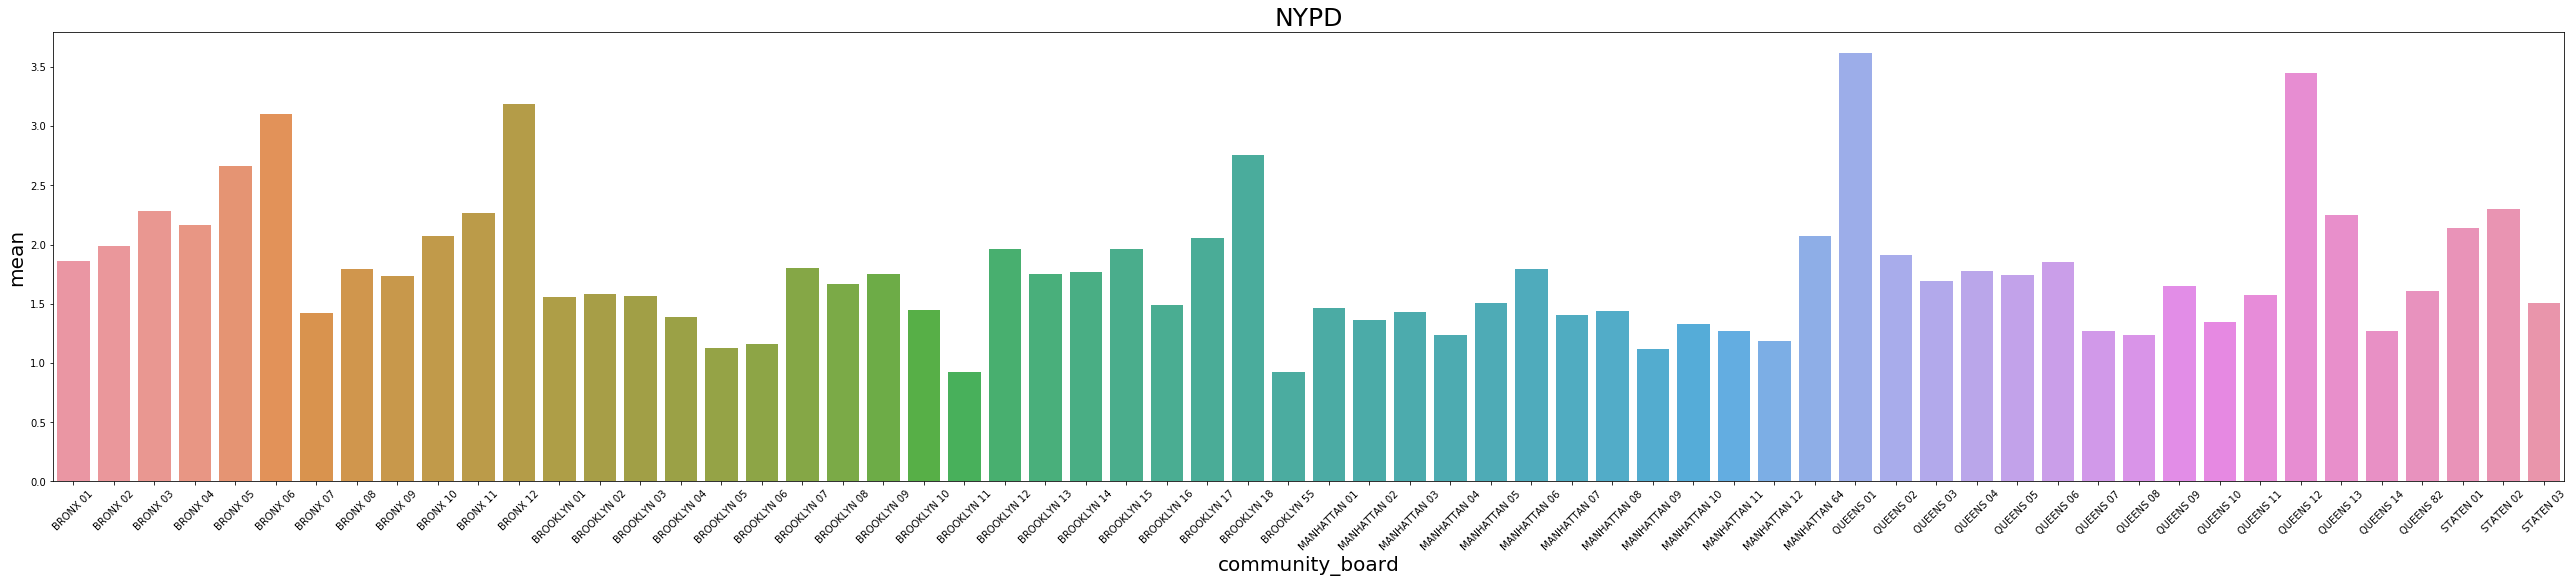

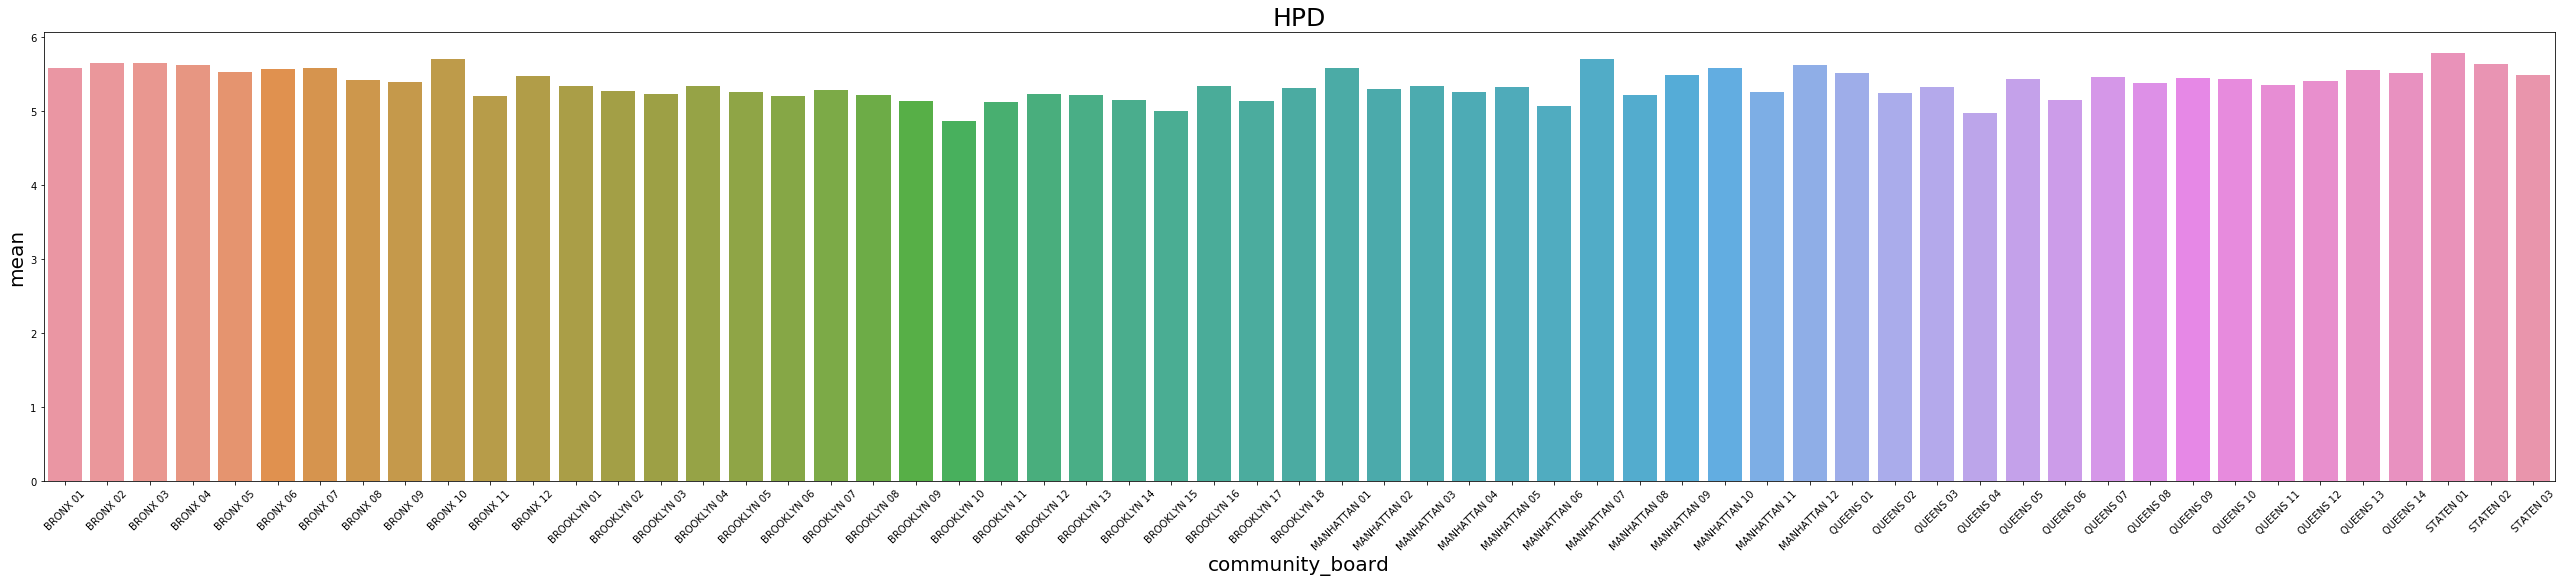

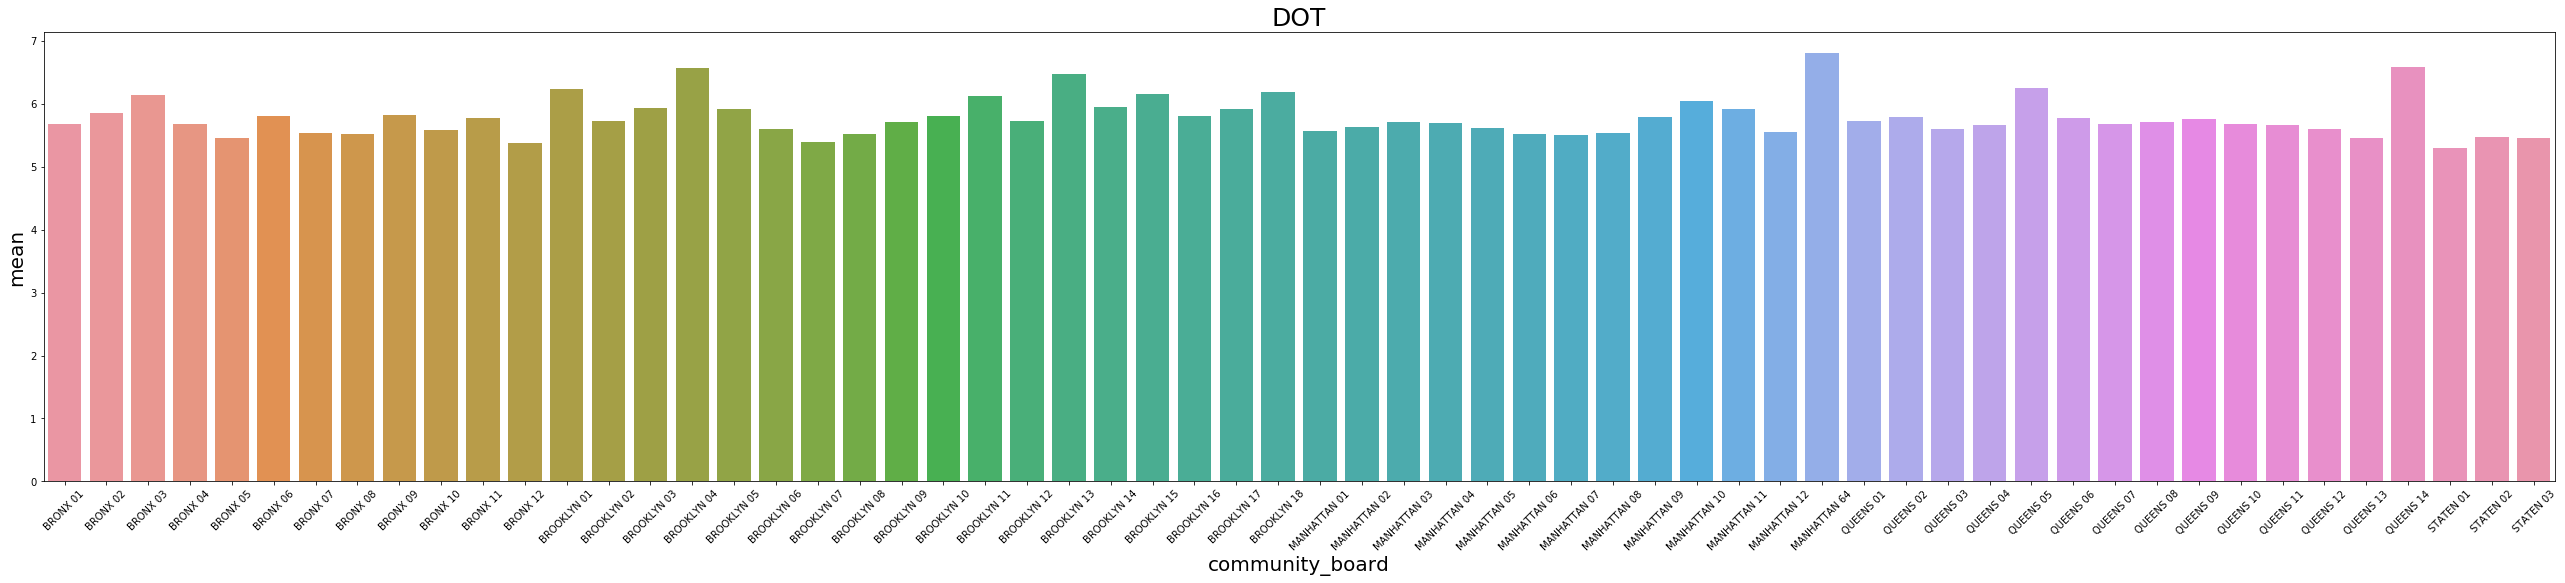

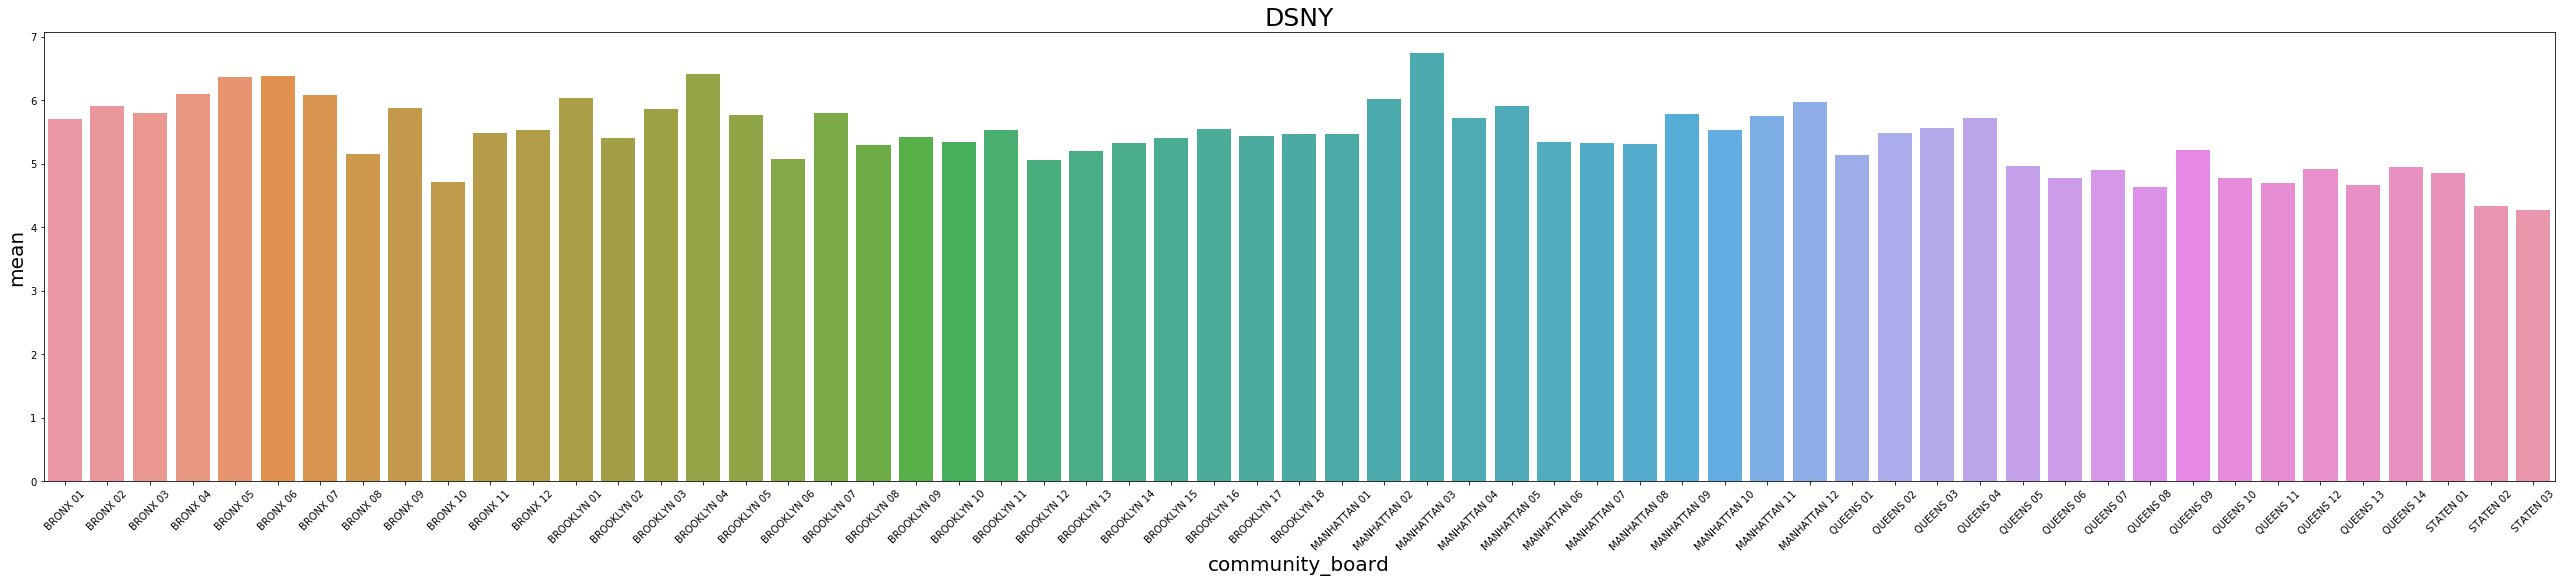

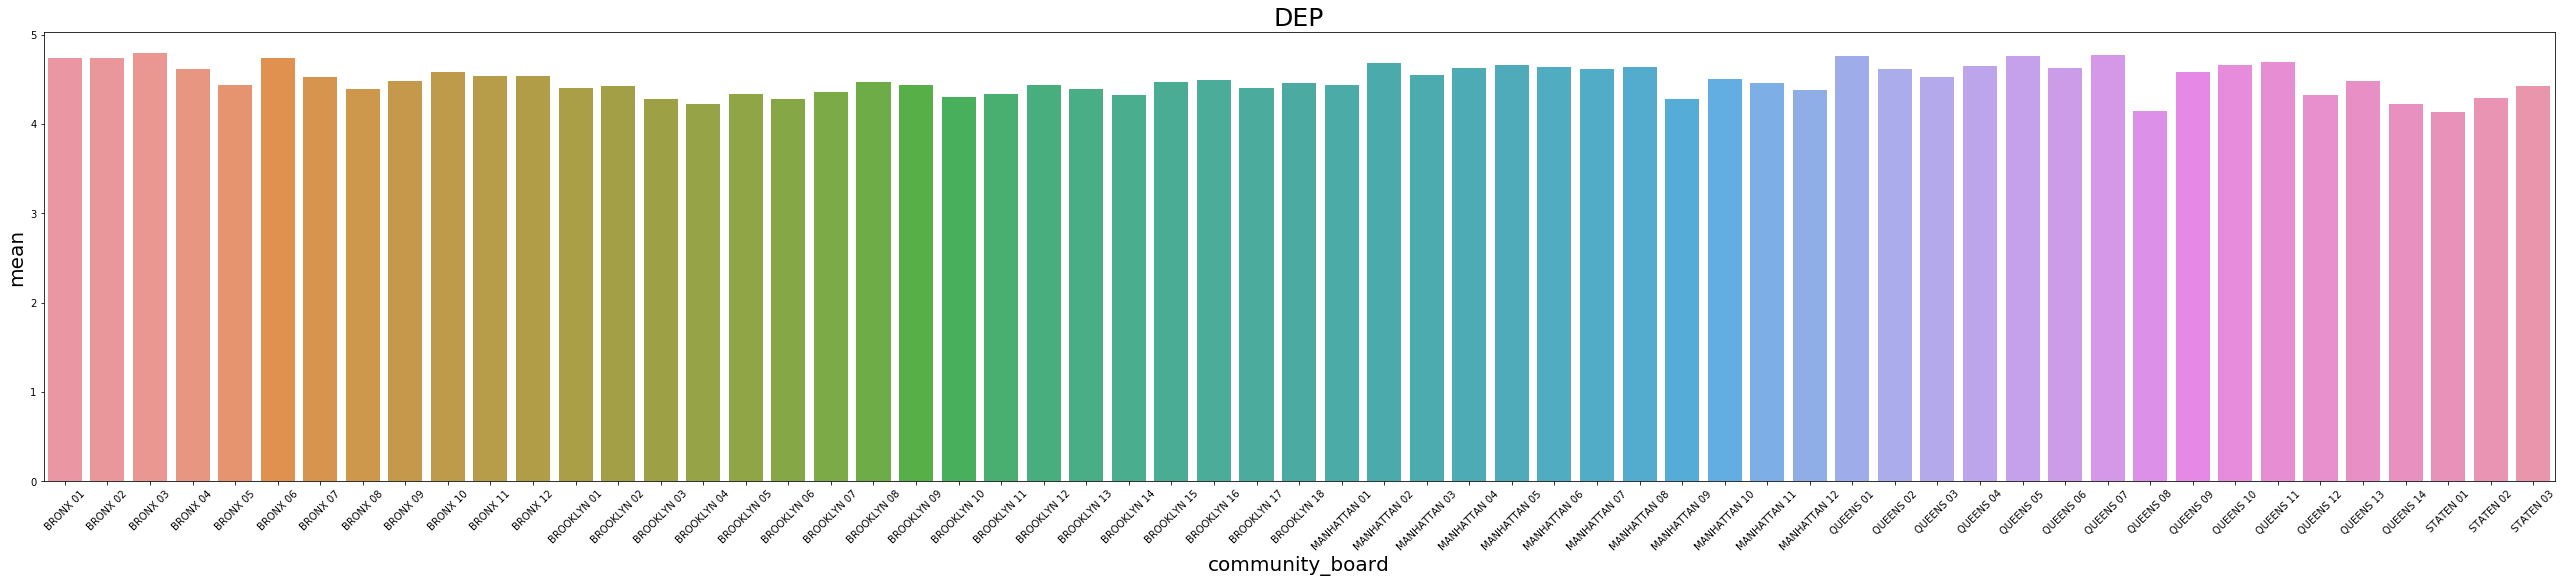

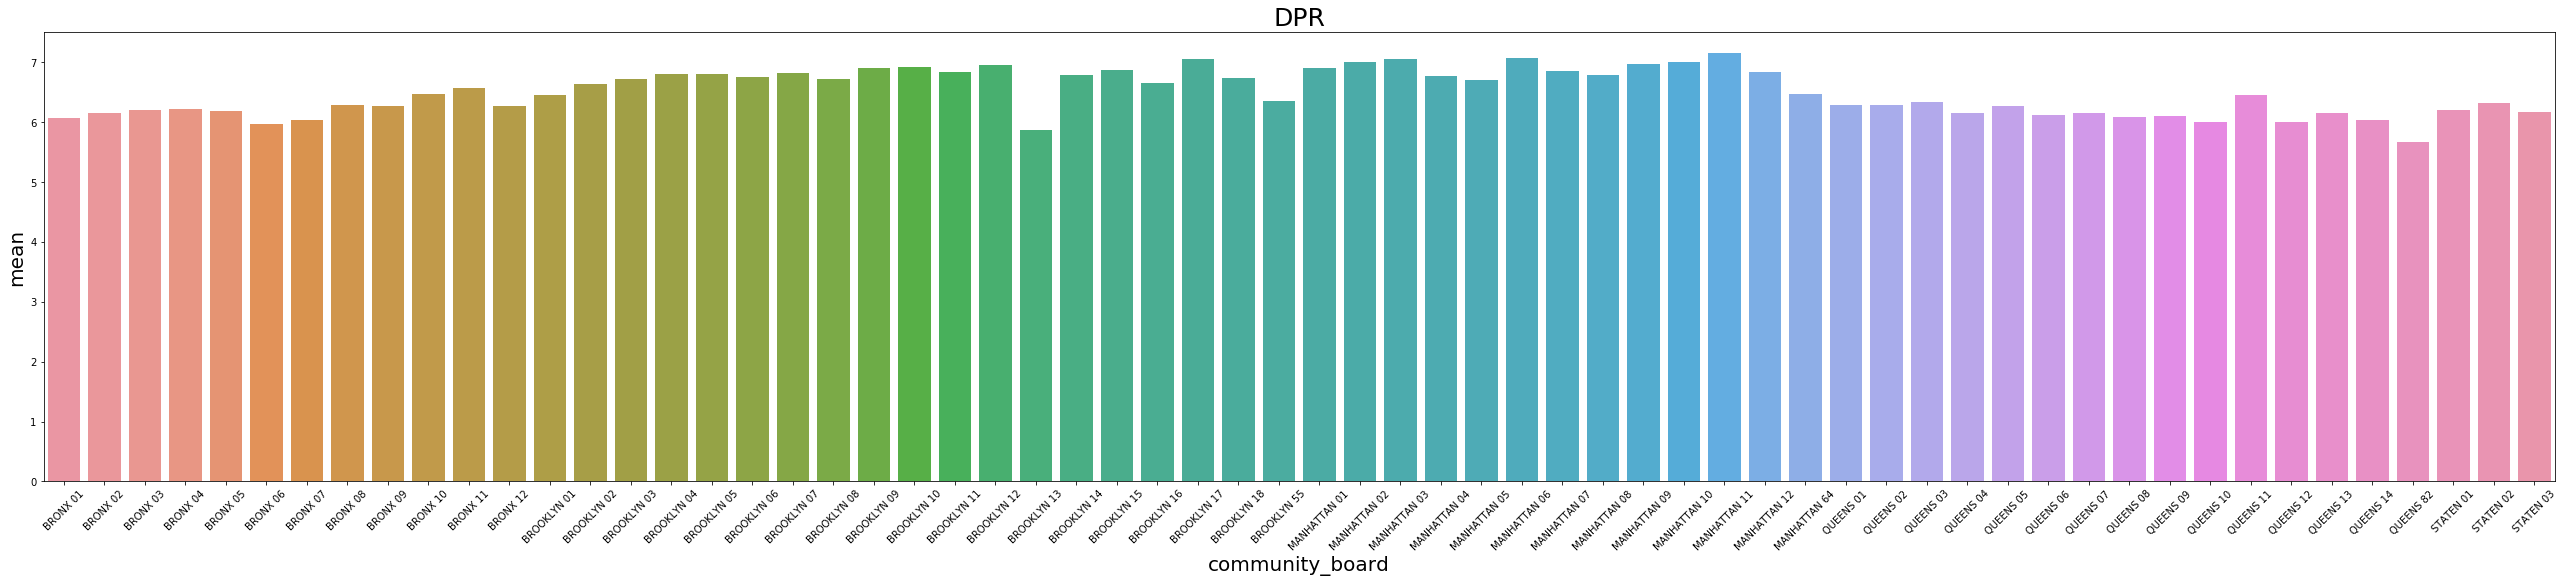

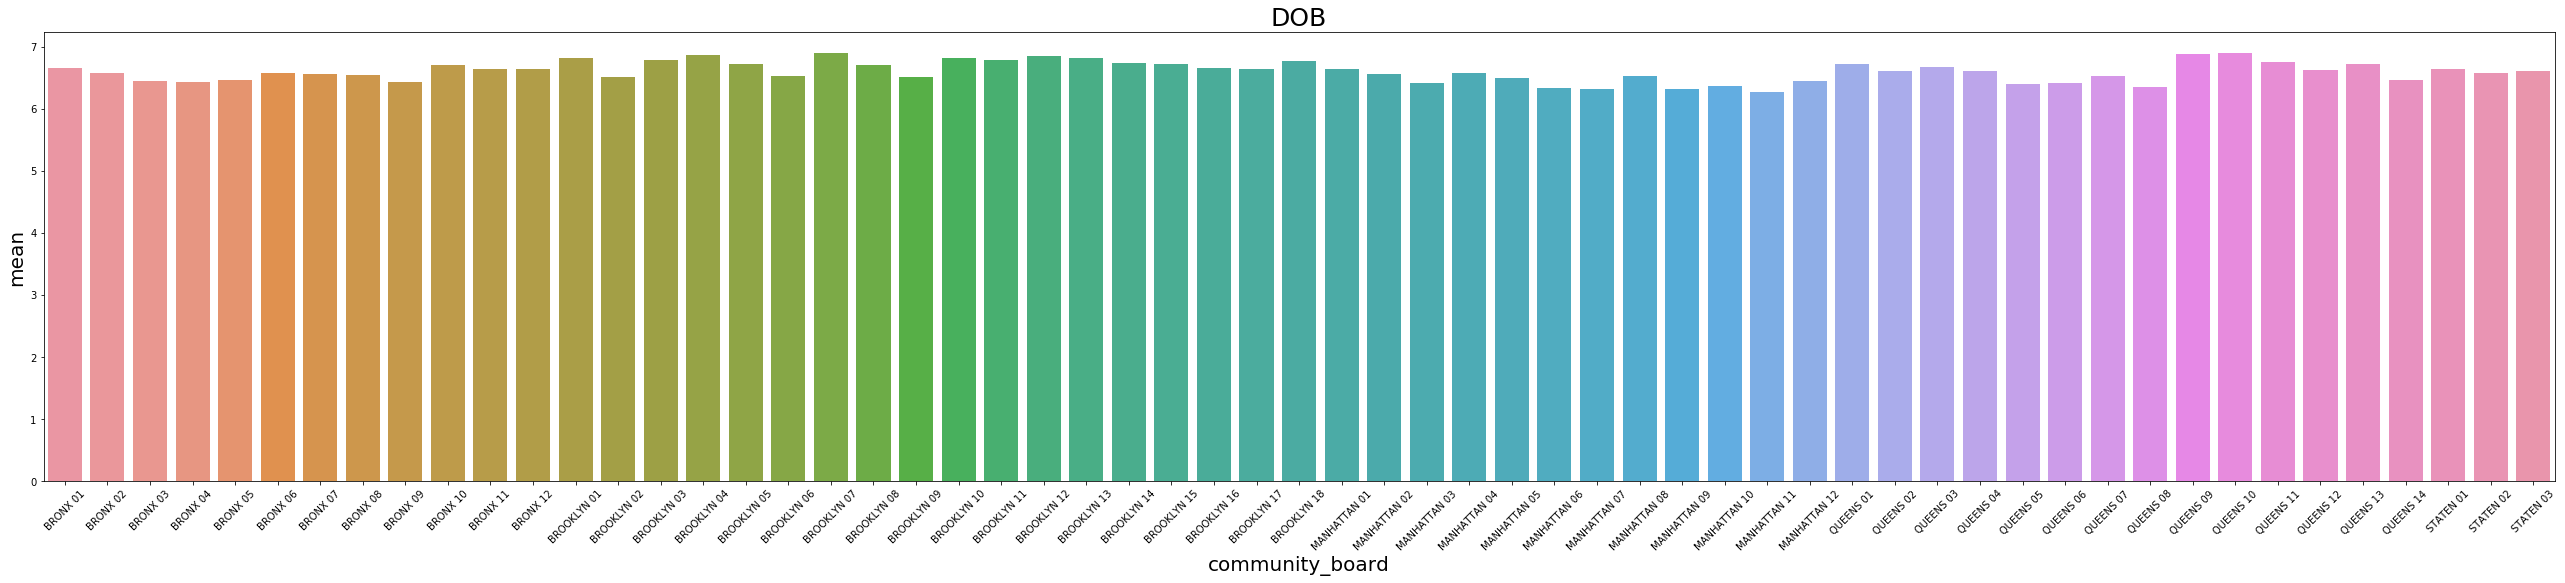

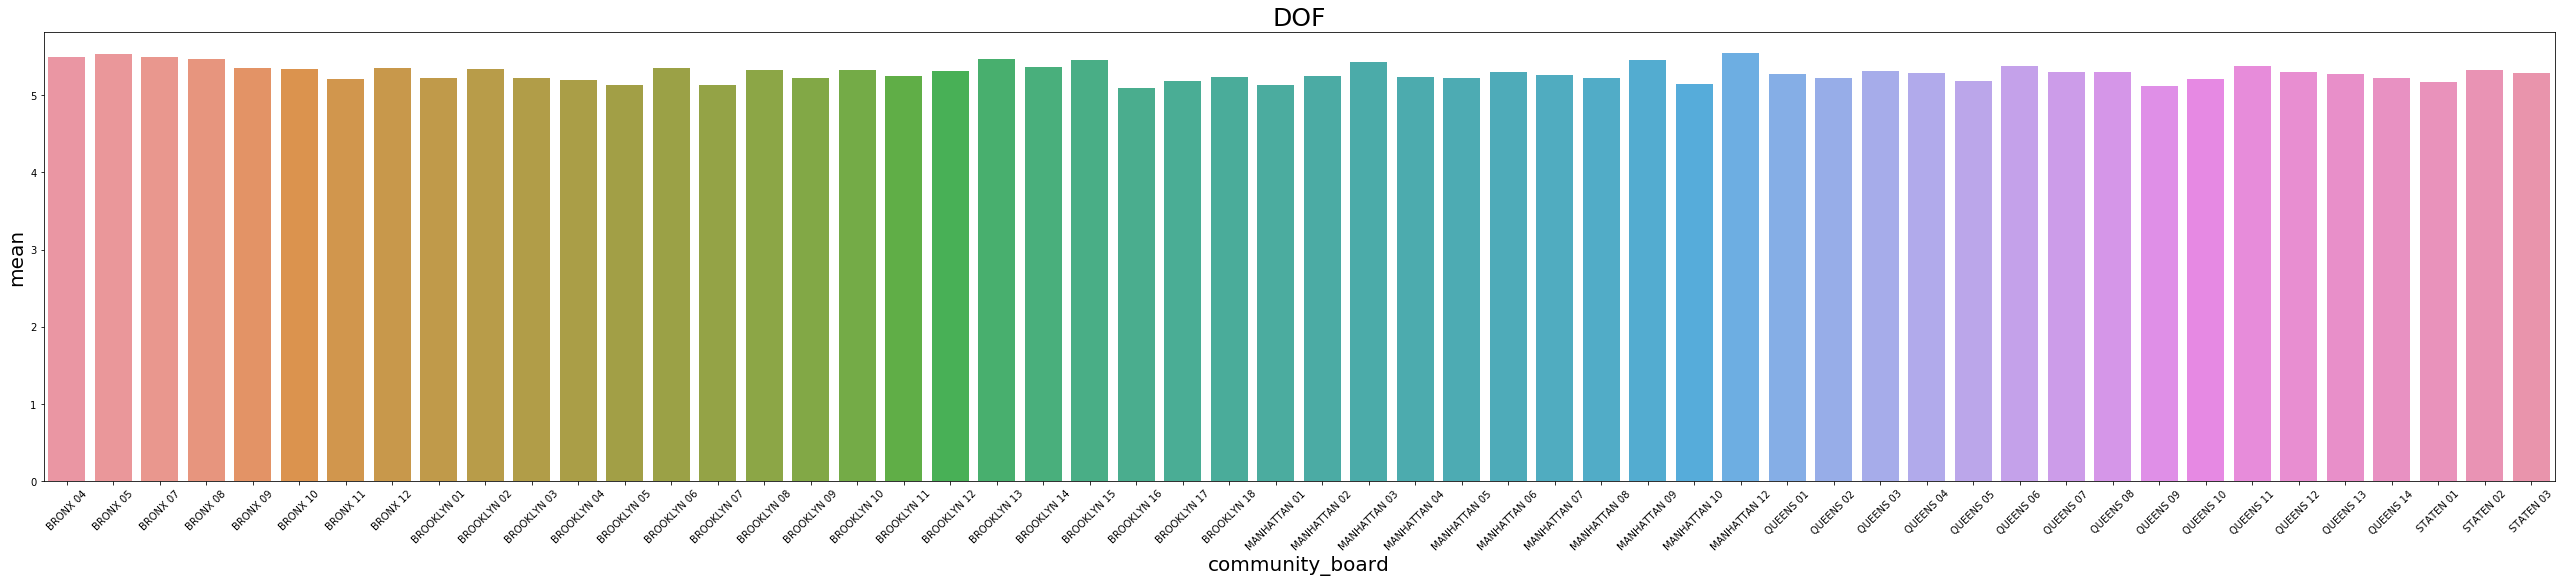

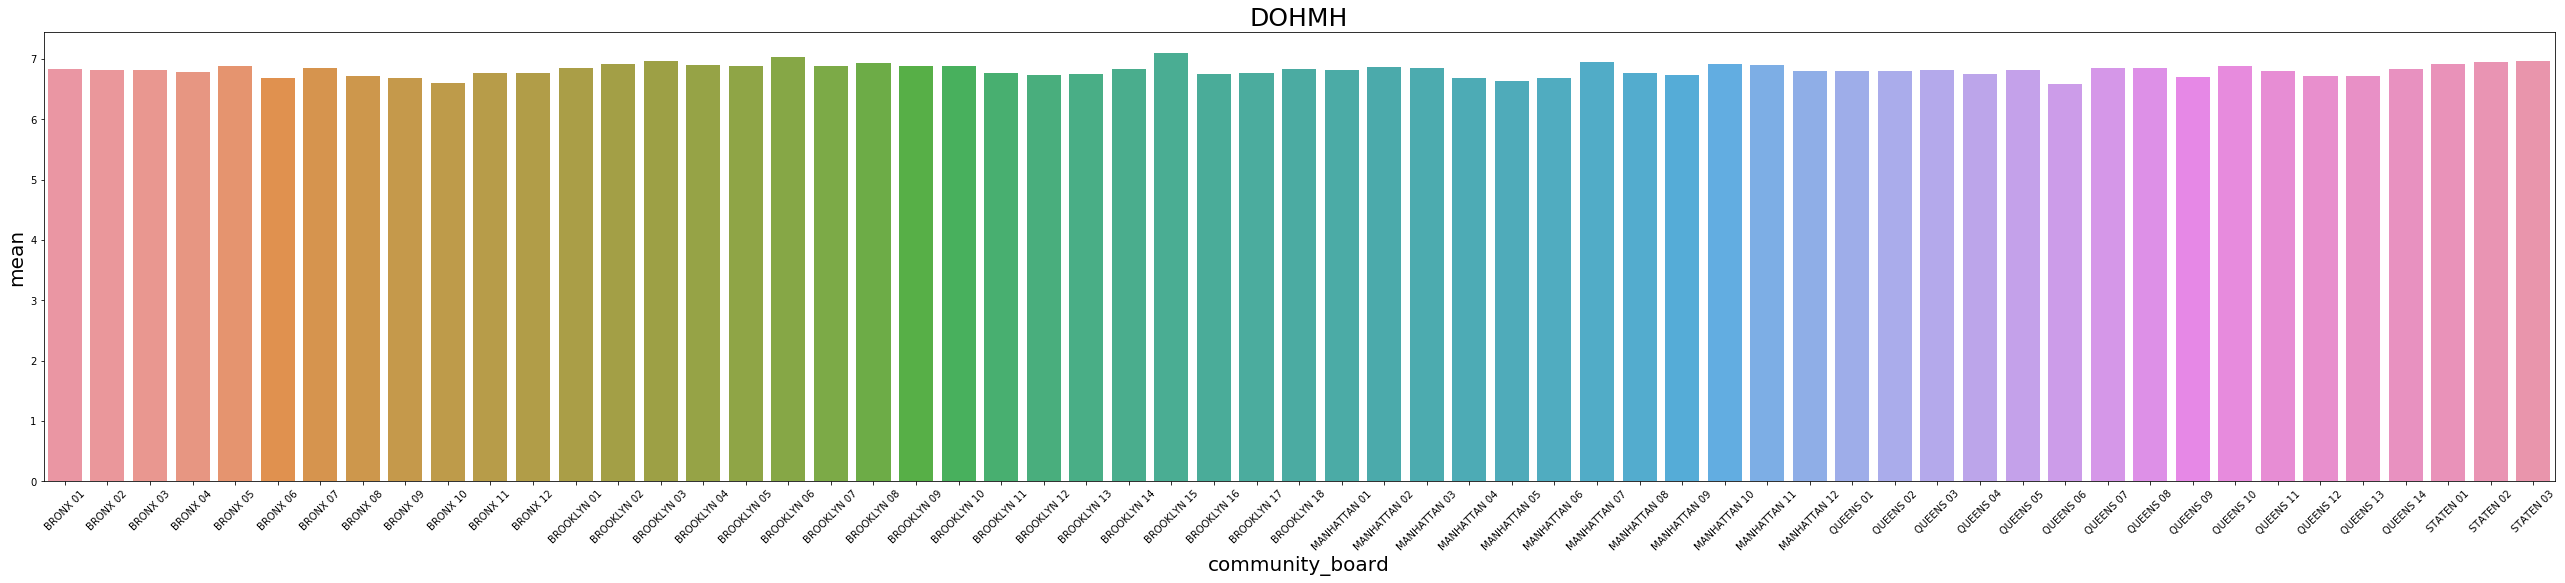

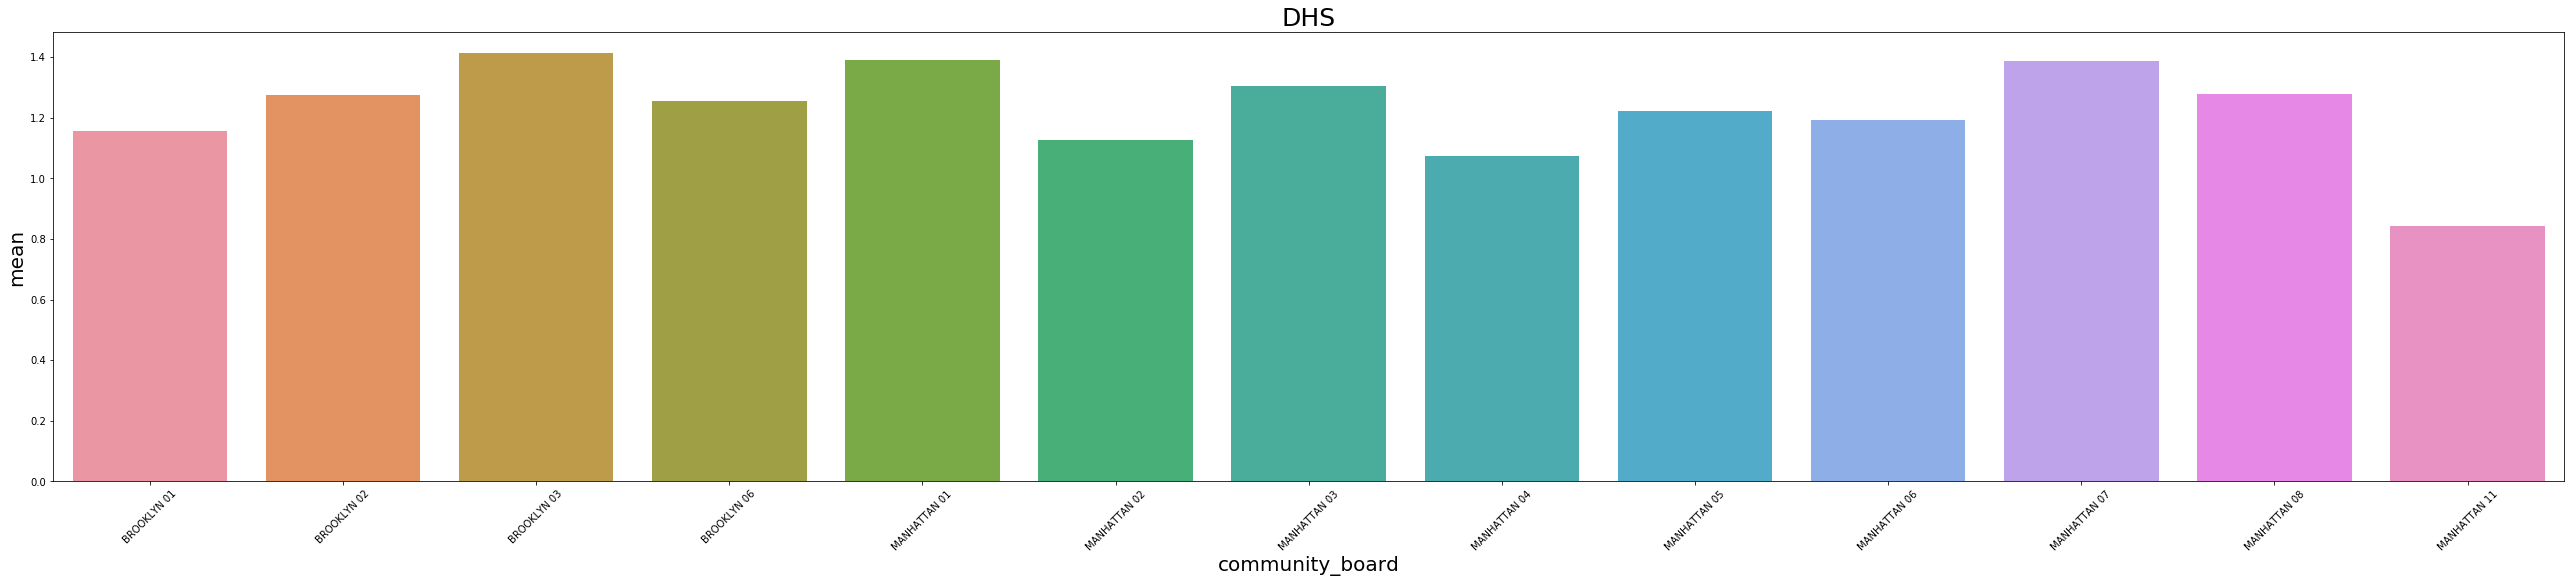

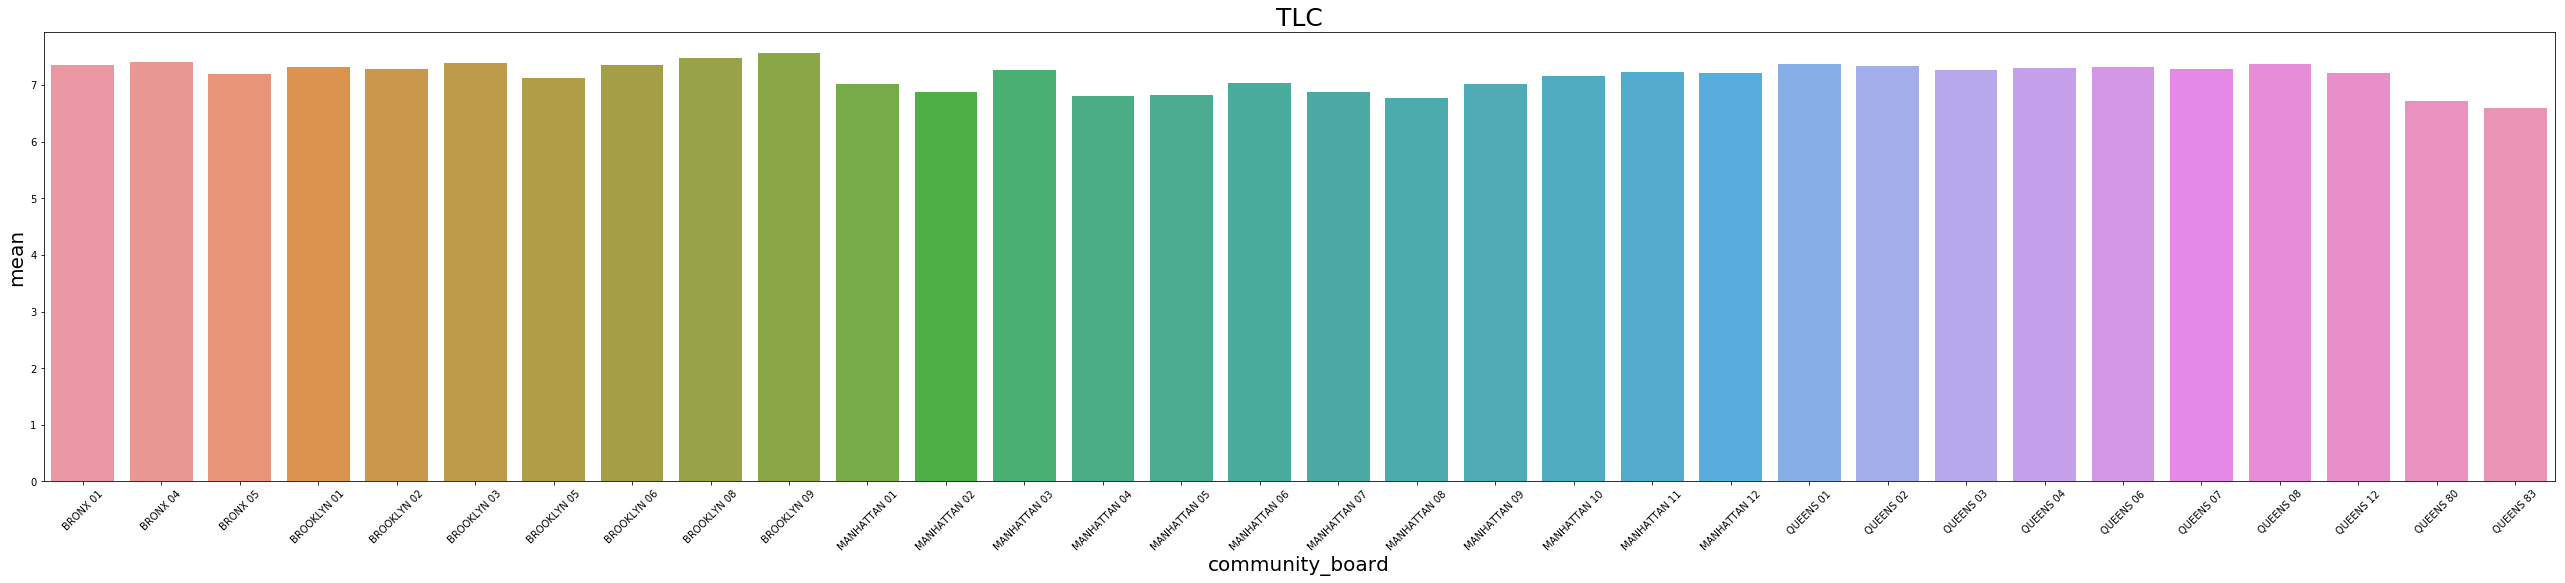

In [125]:
#visually breaks down agency performance by board
x= 'community_board'
y= 'mean'
a4_dims = (45, 8.27)

for i in range(len(agency_list)):
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.set_title(agency_name_list[i], fontsize=25)
    ax.set_xlabel("community_board",fontsize=20)
    ax.set_ylabel("Mean Completion Time",fontsize=20)
    agencyboardplot = sns.barplot(x, y, data=agency_list[i], ax=ax)
    agencyboardplot.set_xticklabels(agencyboardplot.get_xticklabels(), rotation=45)


In [126]:
#looking at community board breakdown by complaint type so that we can take a closer look at what might be going on with NYPD Response times
boards_complaint_type = db_filtered.groupby(['community_board','agency','complaint_type'])
board_comp_agg = boards_complaint_type['response_time_hours'].agg(['count','mean','std']).sort_values(by = ['community_board','agency','complaint_type','mean','count'])
board_comp_agg = board_comp_agg[board_comp_agg['count']>100]
boards_comp_agg_df = board_comp_agg.reset_index()
boards_comp_agg_df = boards_comp_agg_df[boards_comp_agg_df['community_board'].str.contains('Unspecified') ==False]
boards_comp_agg_df= boards_comp_agg_df.sort_values(by= 'community_board')
boards_comp_agg_df['mean'] = boards_comp_agg_df['mean'].apply(np.log)
boards_comp_agg_df['community_board'] = list(map(lambda x: join(x), boards_comp_agg_df['community_board'])) 



In [127]:
nypd_comps = boards_comp_agg_df[boards_comp_agg_df['agency']=='NYPD'].sort_values(by='community_board')

In [128]:
illegal_parking = nypd_comps[nypd_comps['complaint_type']=='Illegal Parking'].sort_values(by='community_board')

noise_street_sidewalk = nypd_comps[nypd_comps['complaint_type']=='Noise - Street/Sidewalk'].sort_values(by='community_board')

noise_residential = nypd_comps[nypd_comps['complaint_type']=='Noise - Residential'].sort_values(by='community_board')

blocked_driveway = nypd_comps[nypd_comps['complaint_type']=='Blocked Driveway'].sort_values(by='community_board')

noise_vehicle = nypd_comps[nypd_comps['complaint_type']=='Noise - Vehicle'].sort_values(by='community_board')

noise_commercial = nypd_comps[nypd_comps['complaint_type']=='Noise - Commercial'].sort_values(by='community_board')

animal_abuse = nypd_comps[nypd_comps['complaint_type']=='Animal Abuse'].sort_values(by='community_board')

derelict_vehicle = nypd_comps[nypd_comps['complaint_type']=='Derelict Vehicle'].sort_values(by='community_board')

non_emergency_police_matter = nypd_comps[nypd_comps['complaint_type']=='Non-Emergency Police Matter'].sort_values(by='community_board')

noise_park = nypd_comps[nypd_comps['complaint_type']=='Noise - Park'].sort_values(by='community_board')

traffic = nypd_comps[nypd_comps['complaint_type']=='Traffic'].sort_values(by='community_board')

homeless_encampment = nypd_comps[nypd_comps['complaint_type']=='Homeless Encampment'].sort_values(by='community_board')

vending = nypd_comps[nypd_comps['complaint_type']=='Vending'].sort_values(by='community_board')

nypd_complaint_list = ['illegal_parking','noise_street_sidewalk','noise_residential','blocked_driveway','noise_vehicle',
                      'noise_commercial','animal_abuse','derelict_vehicle','non_emergency_police_matter','noise_park',
                      'traffic','homeless_encampment','vending']

nypd_complaints = [illegal_parking,noise_street_sidewalk,noise_residential,blocked_driveway,noise_vehicle,
                      noise_commercial,animal_abuse,derelict_vehicle,non_emergency_police_matter,noise_park,
                      traffic,homeless_encampment,vending]

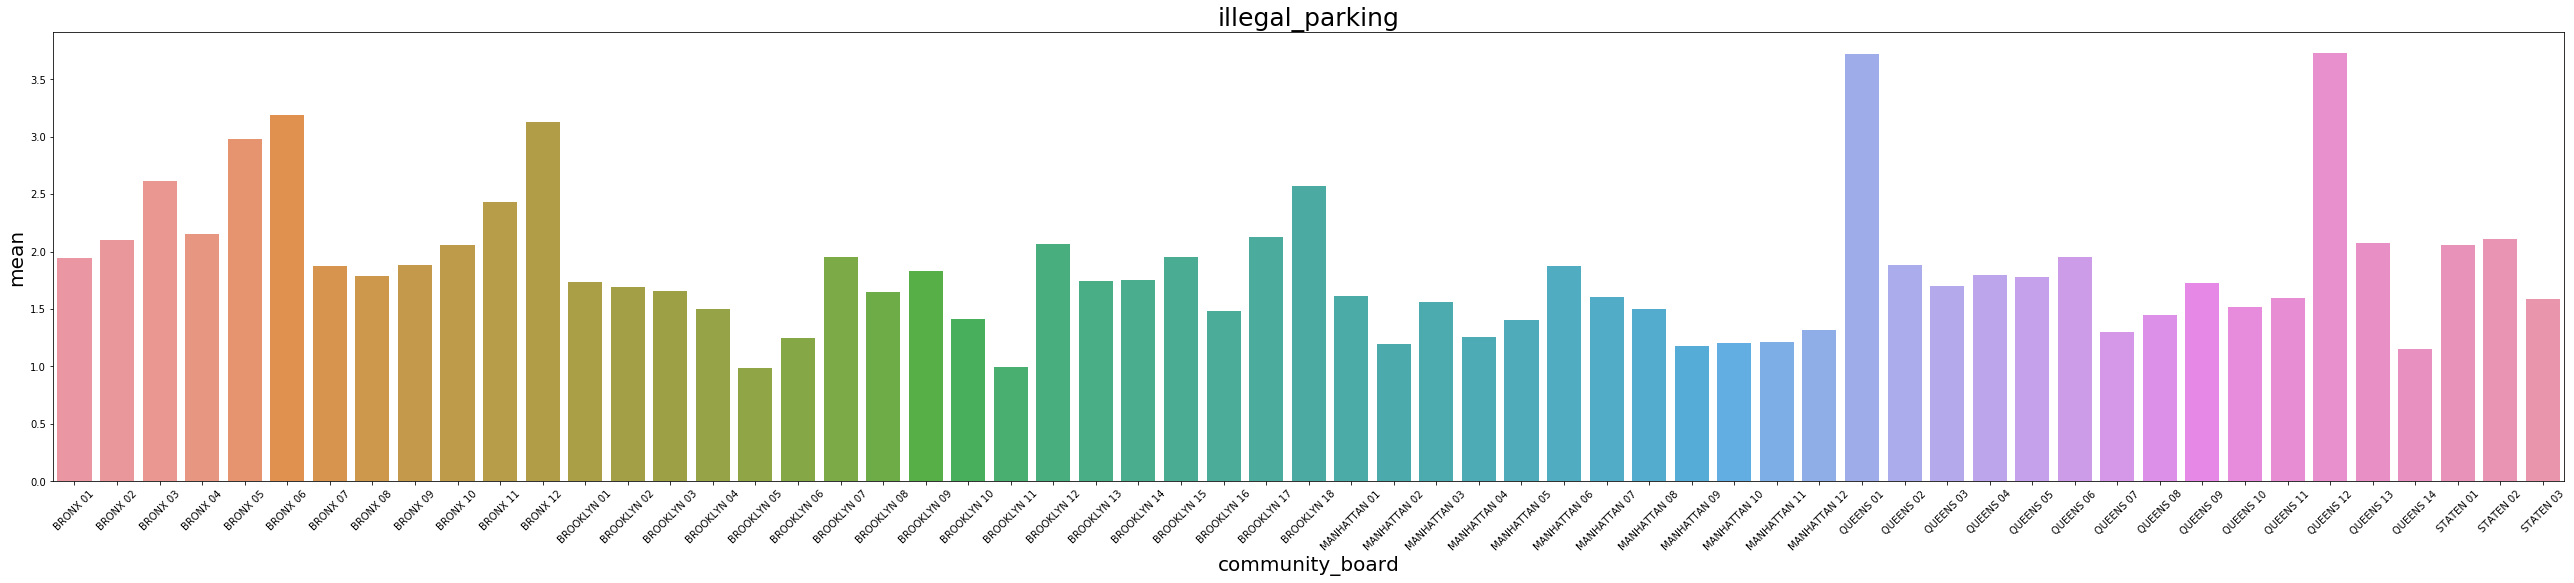

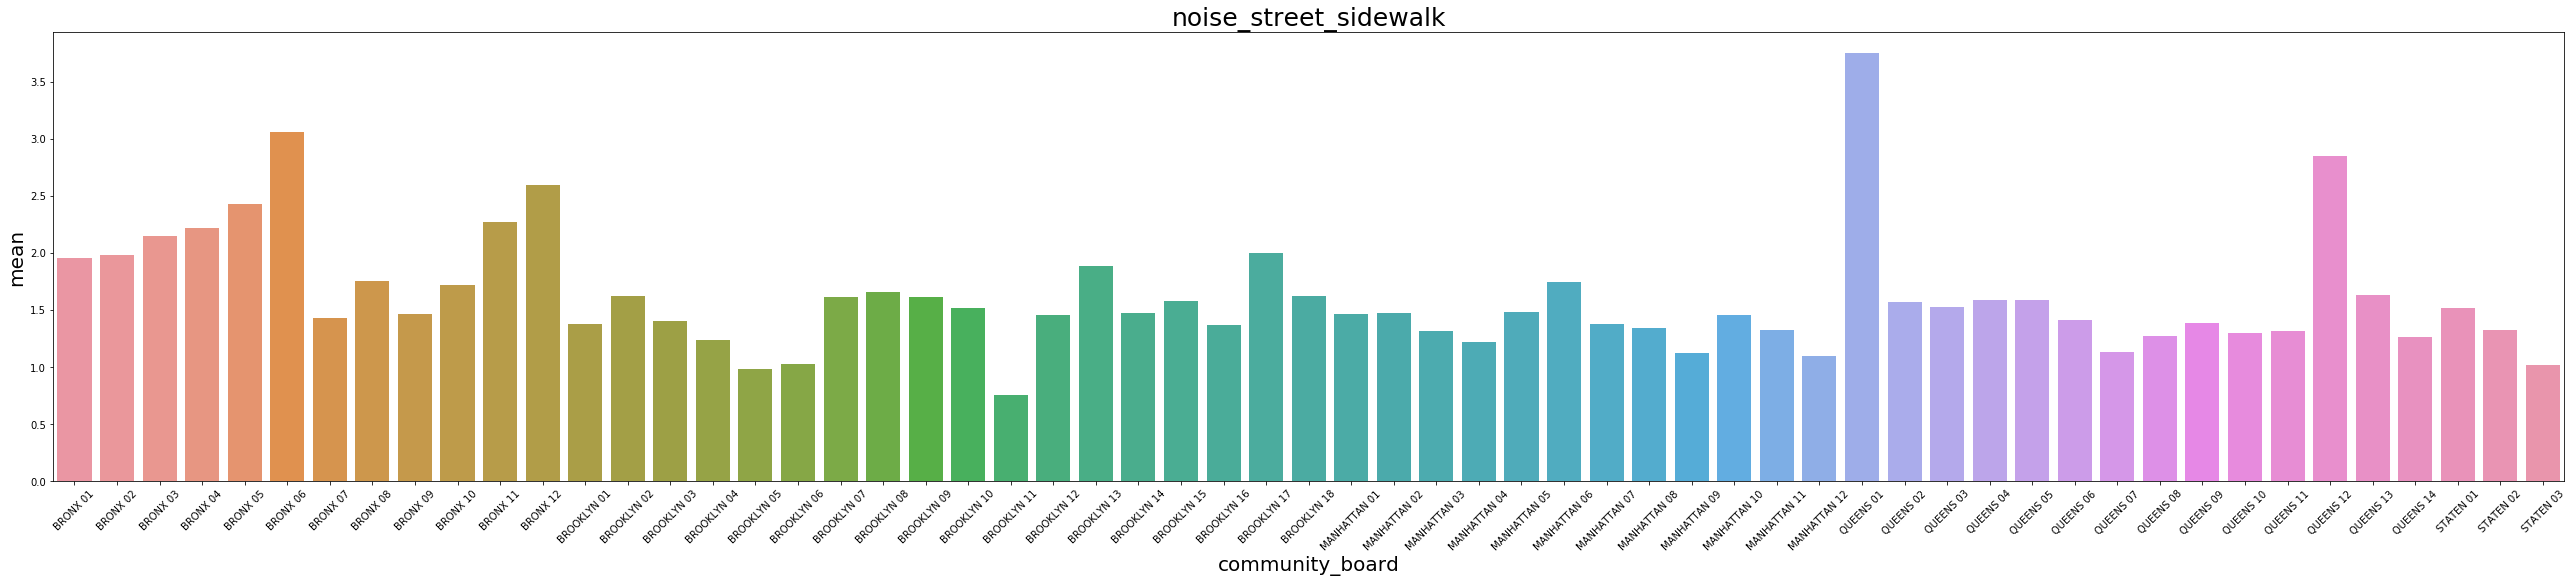

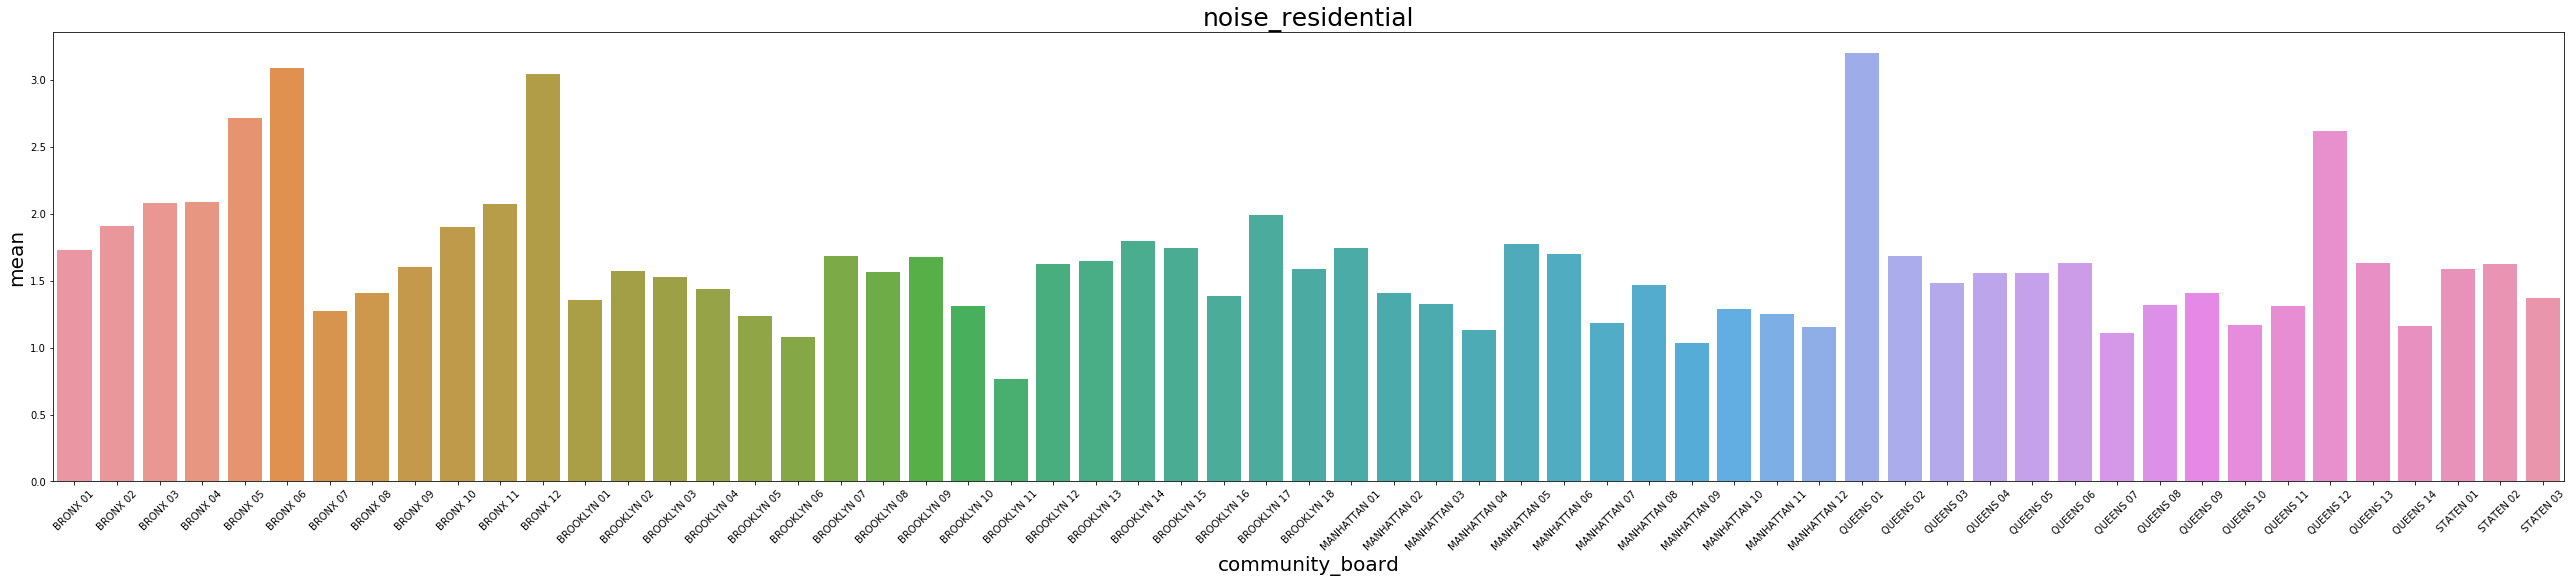

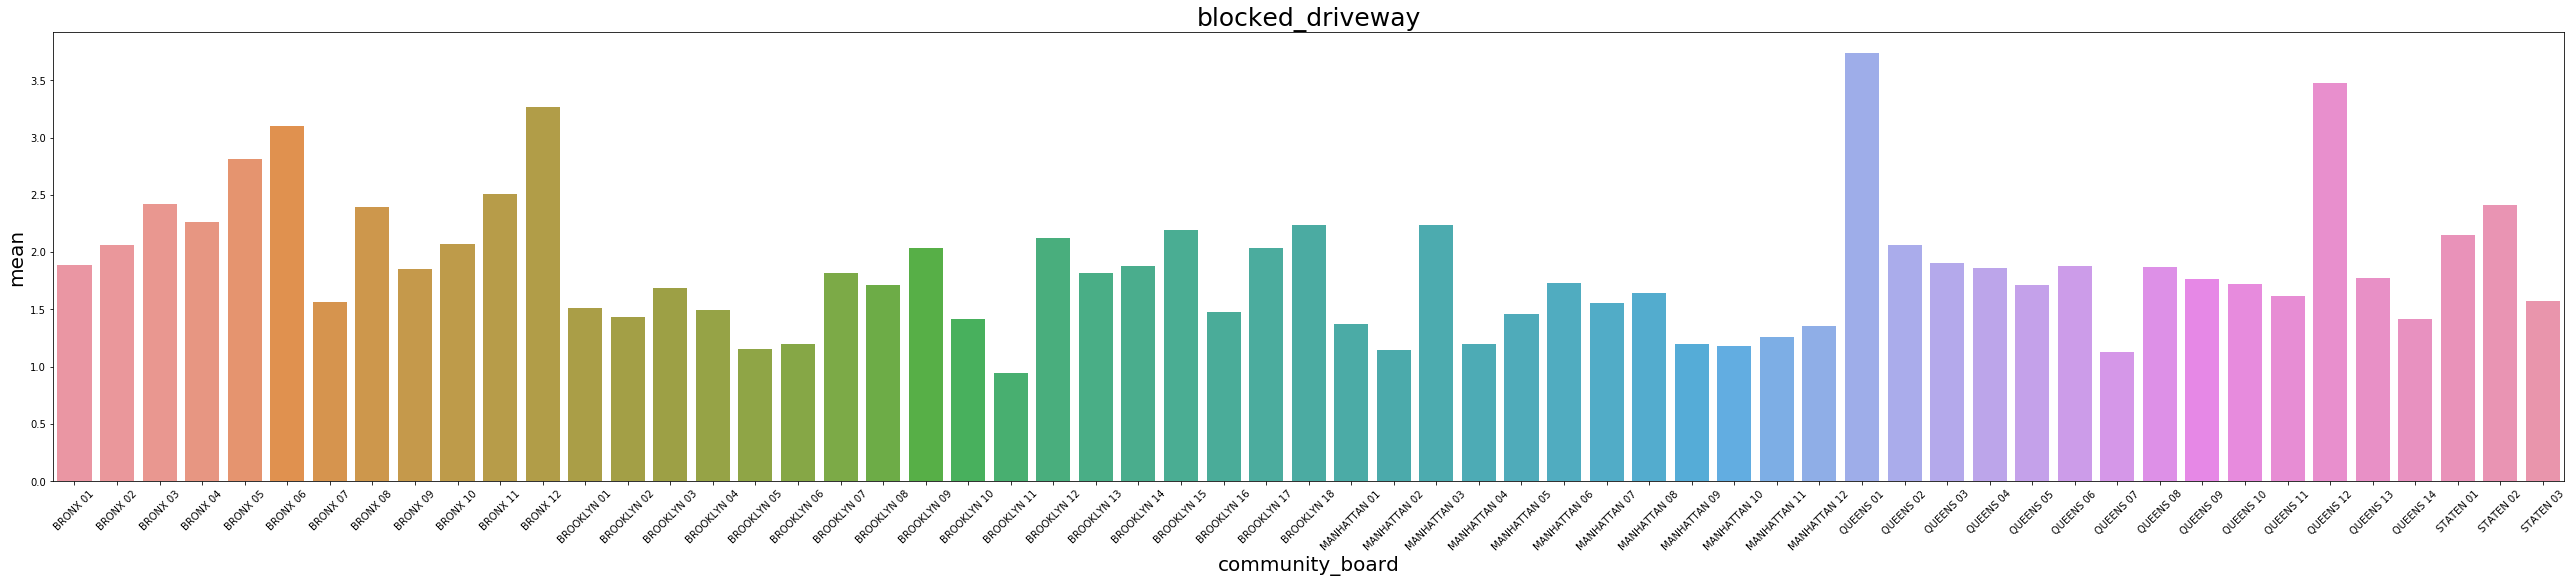

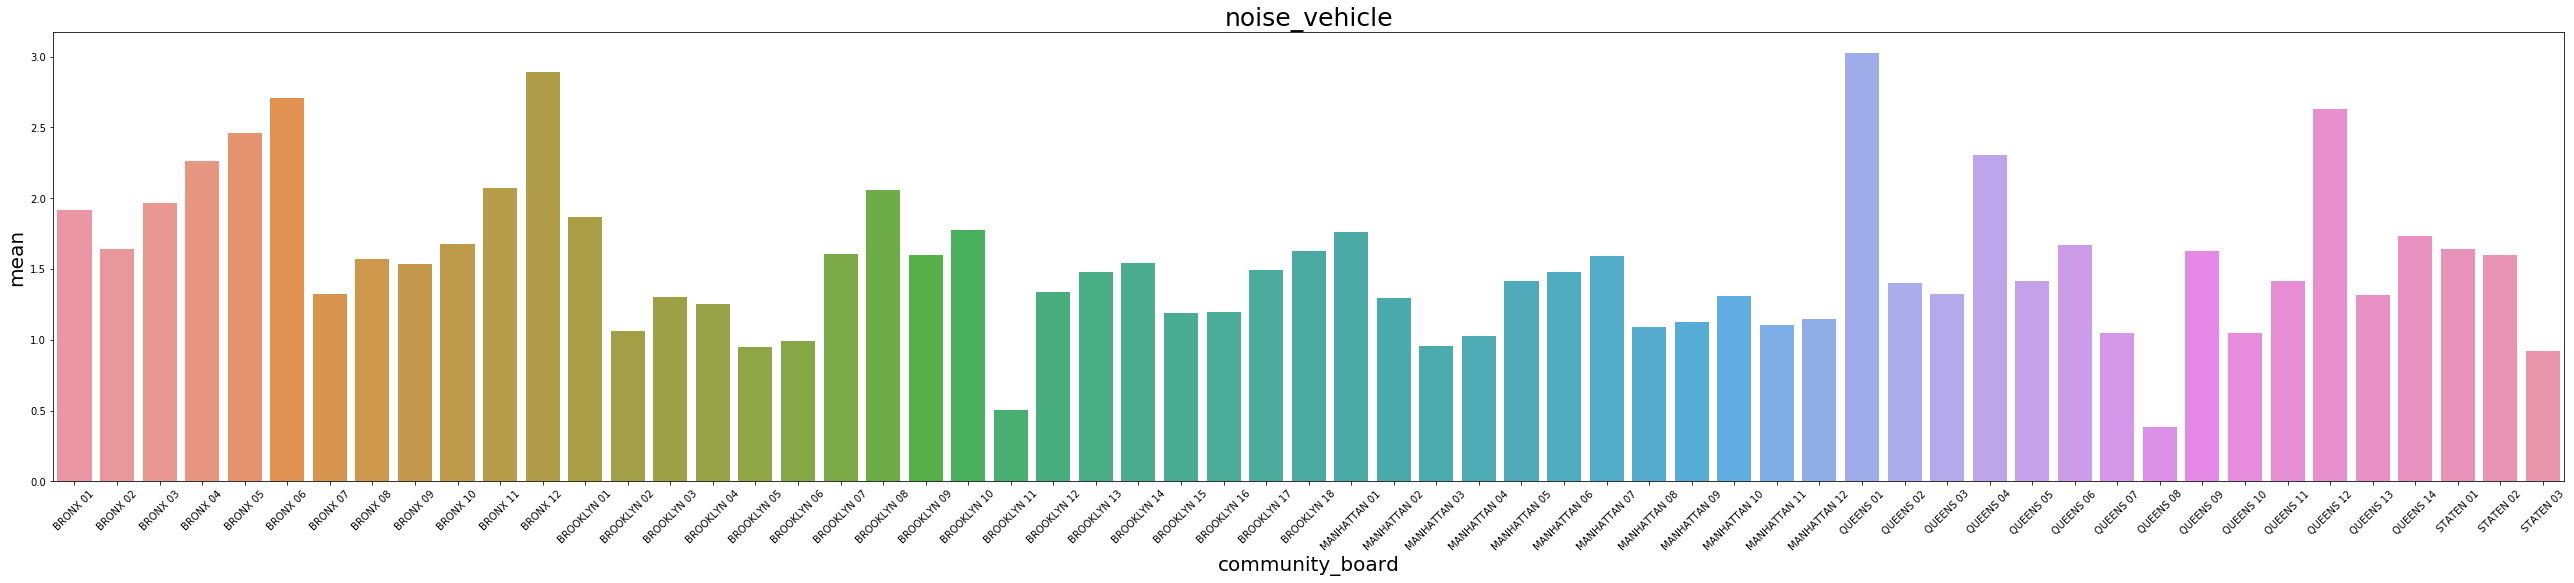

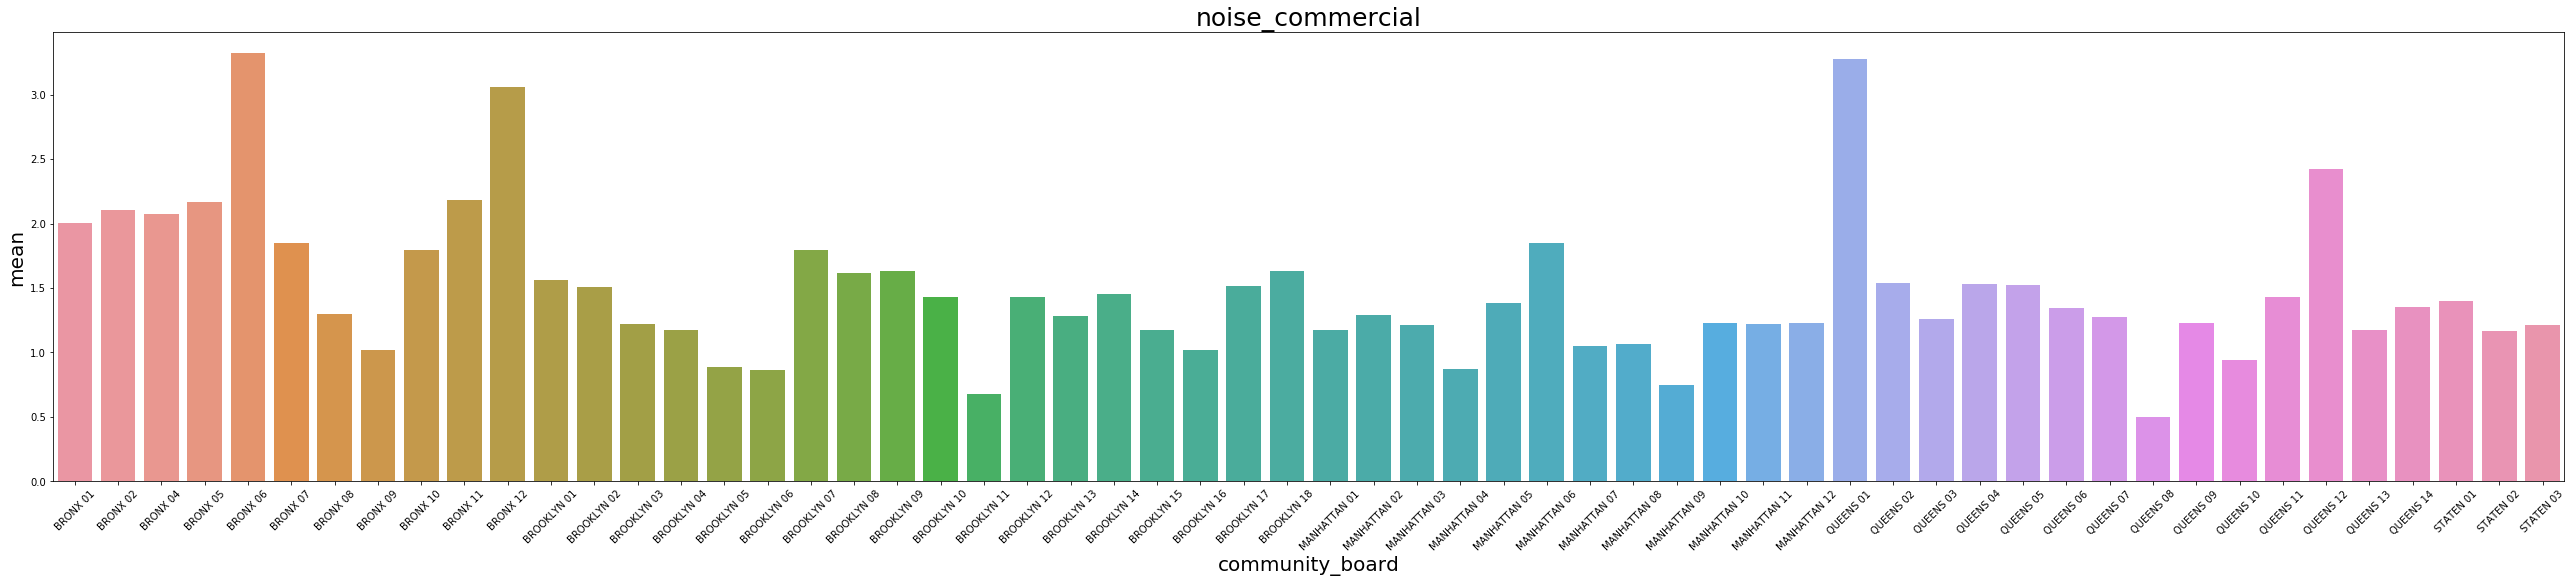

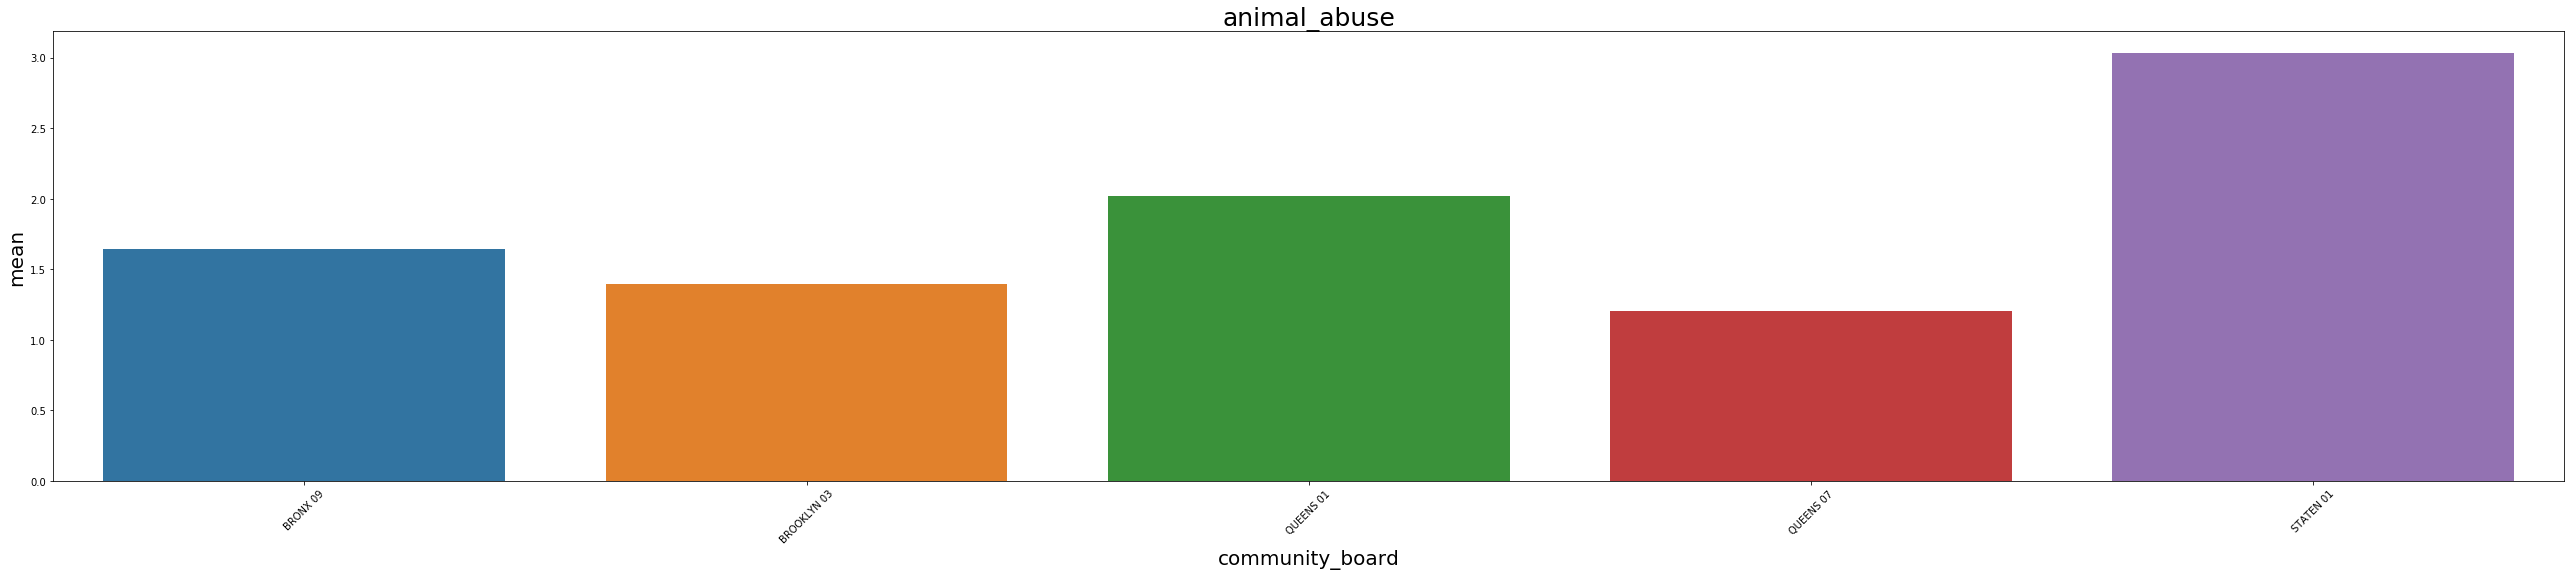

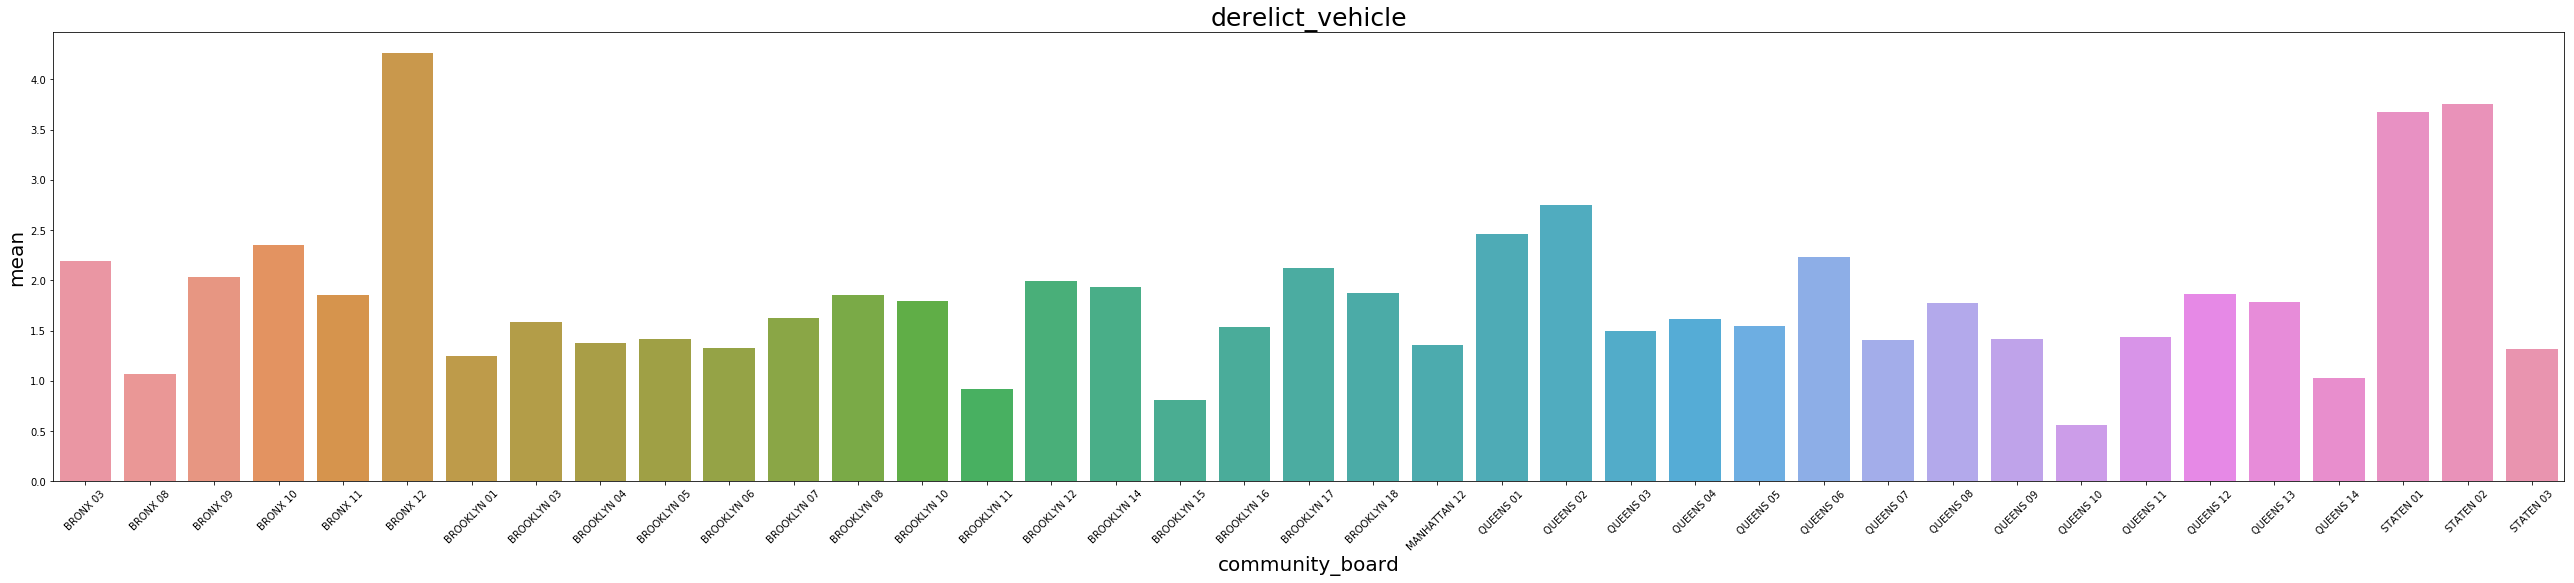

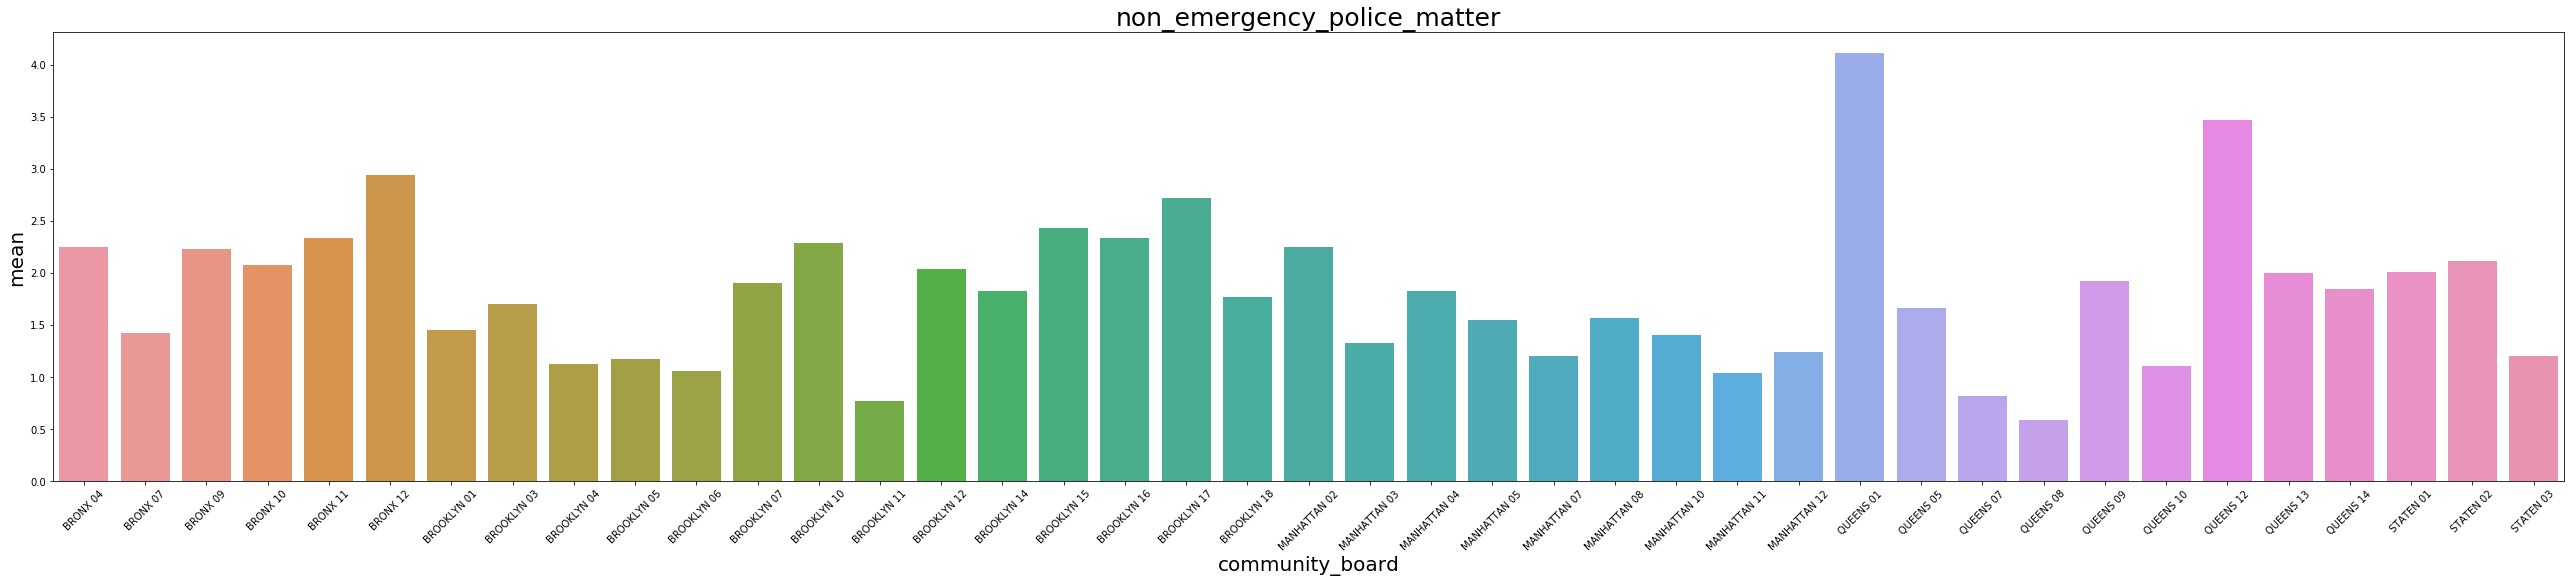

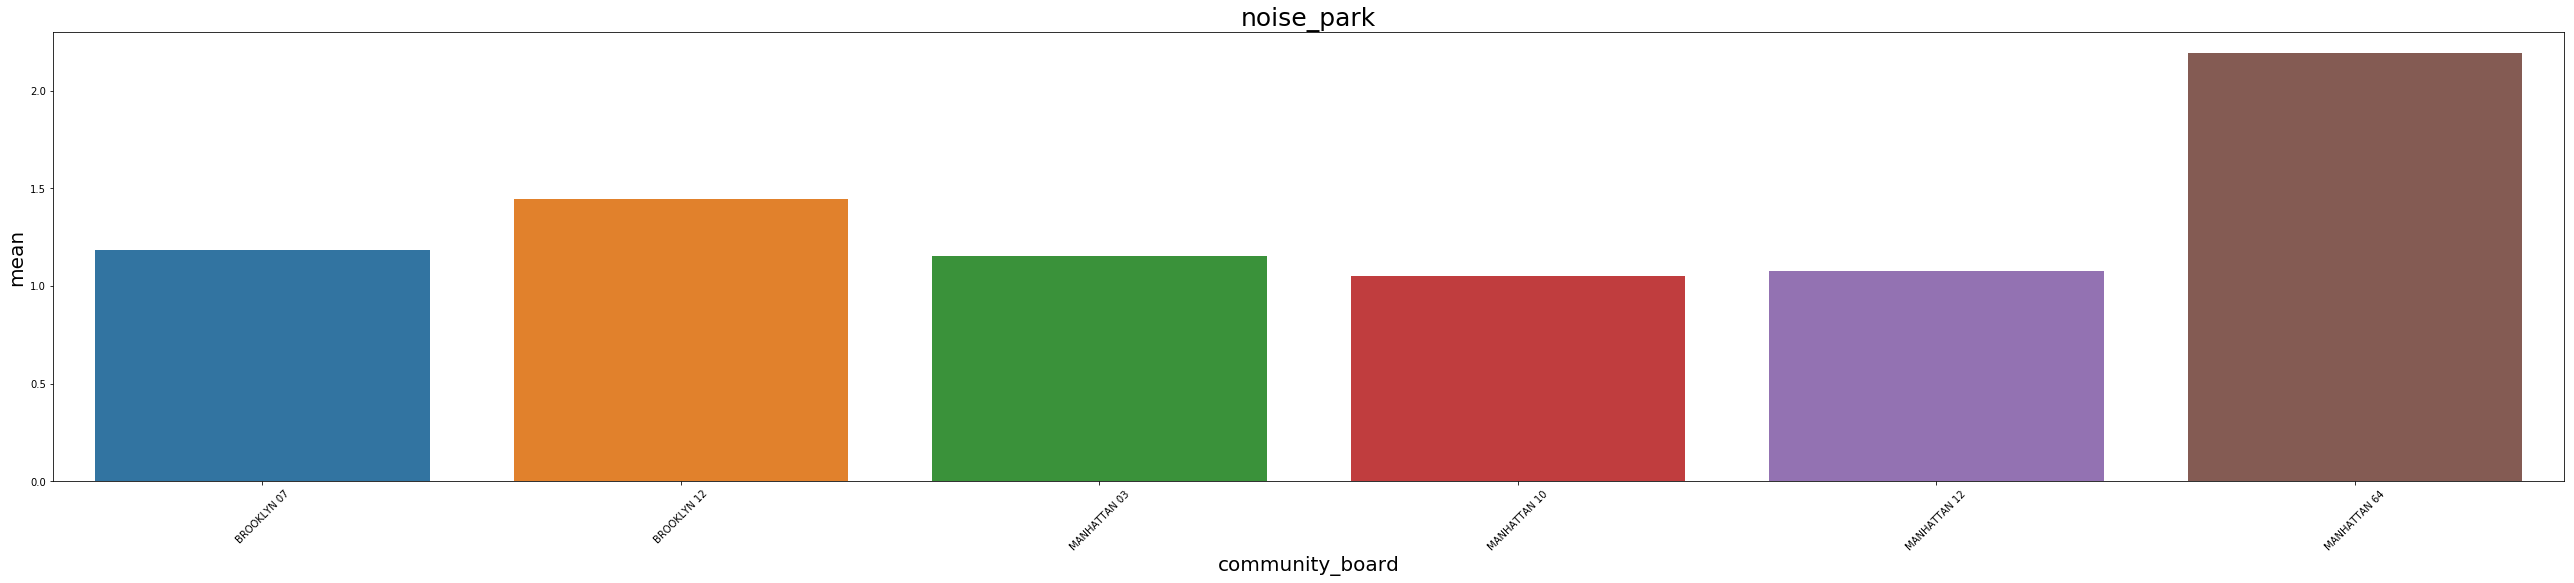

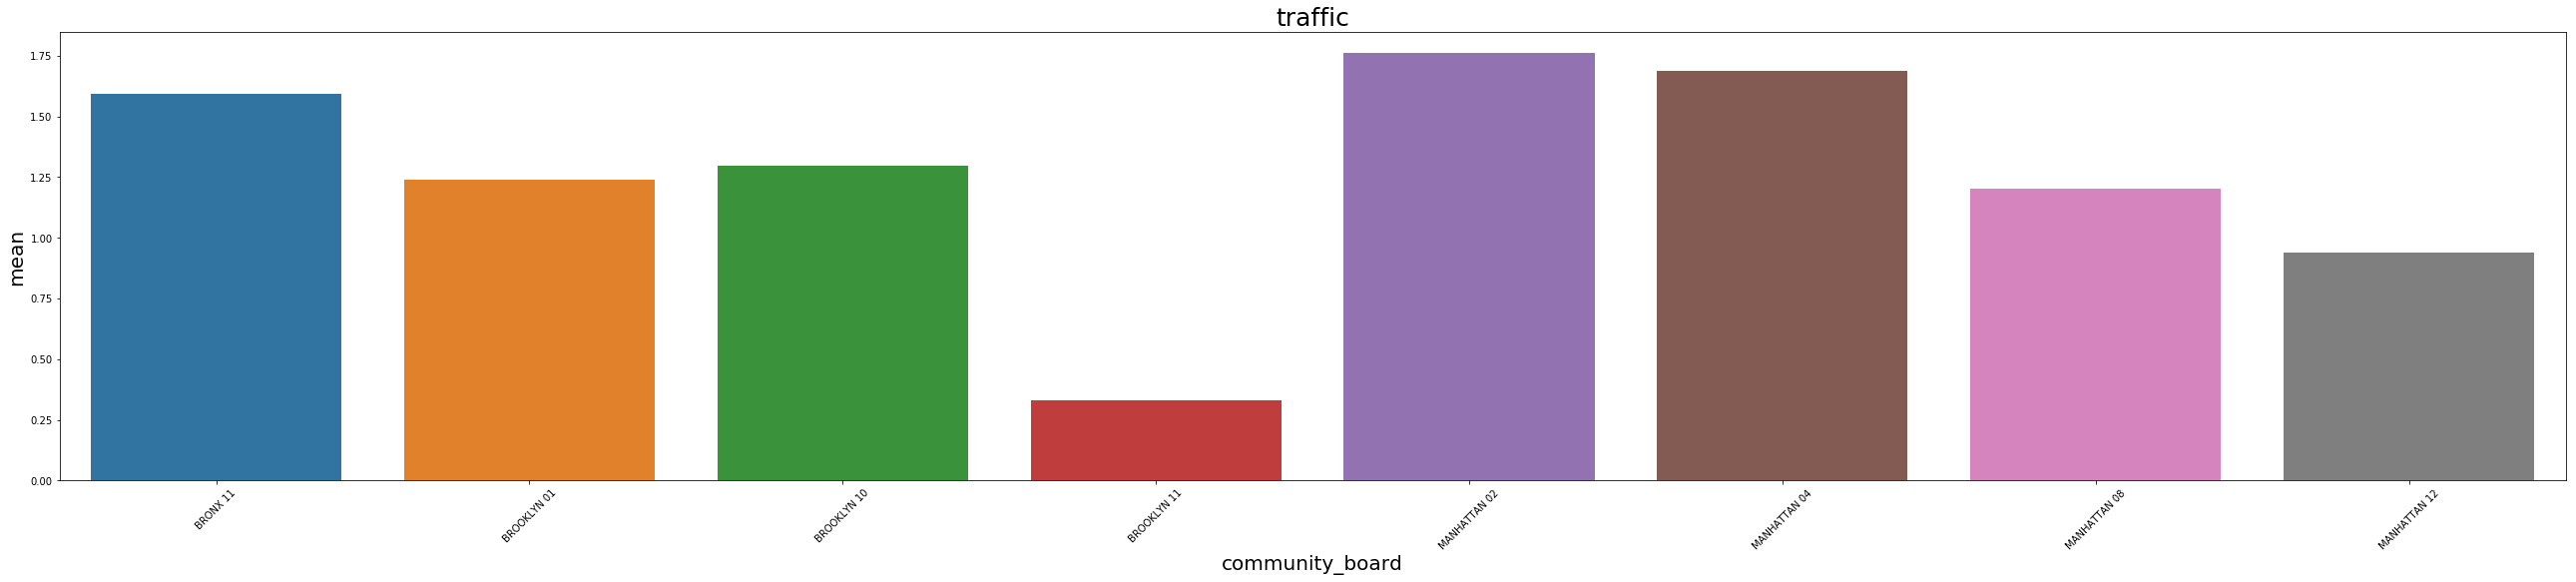

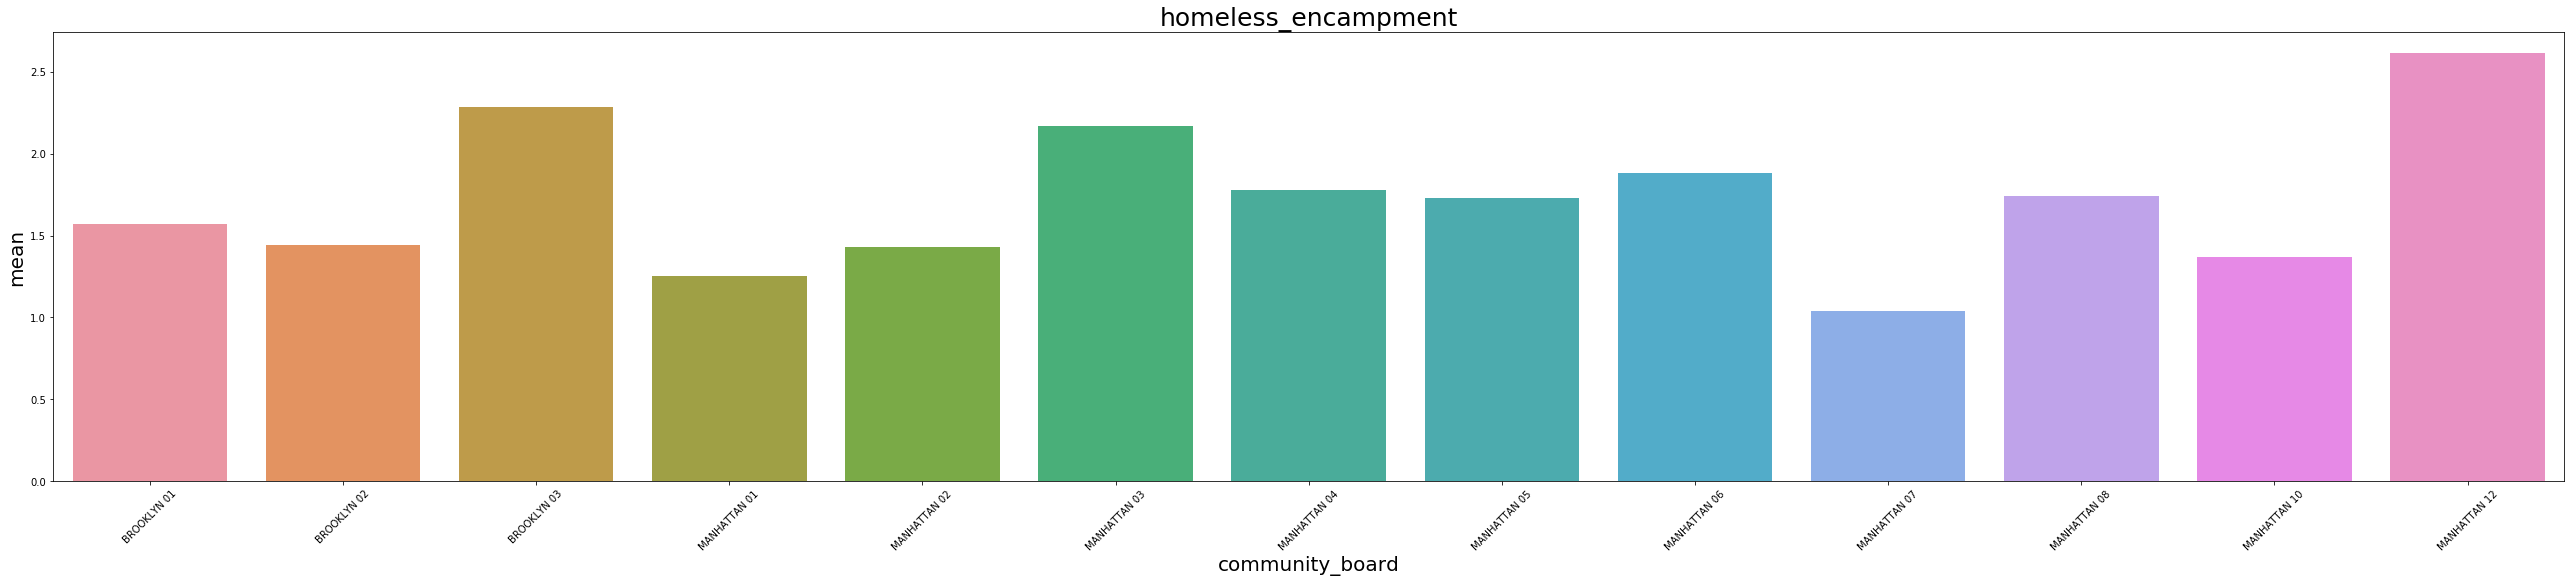

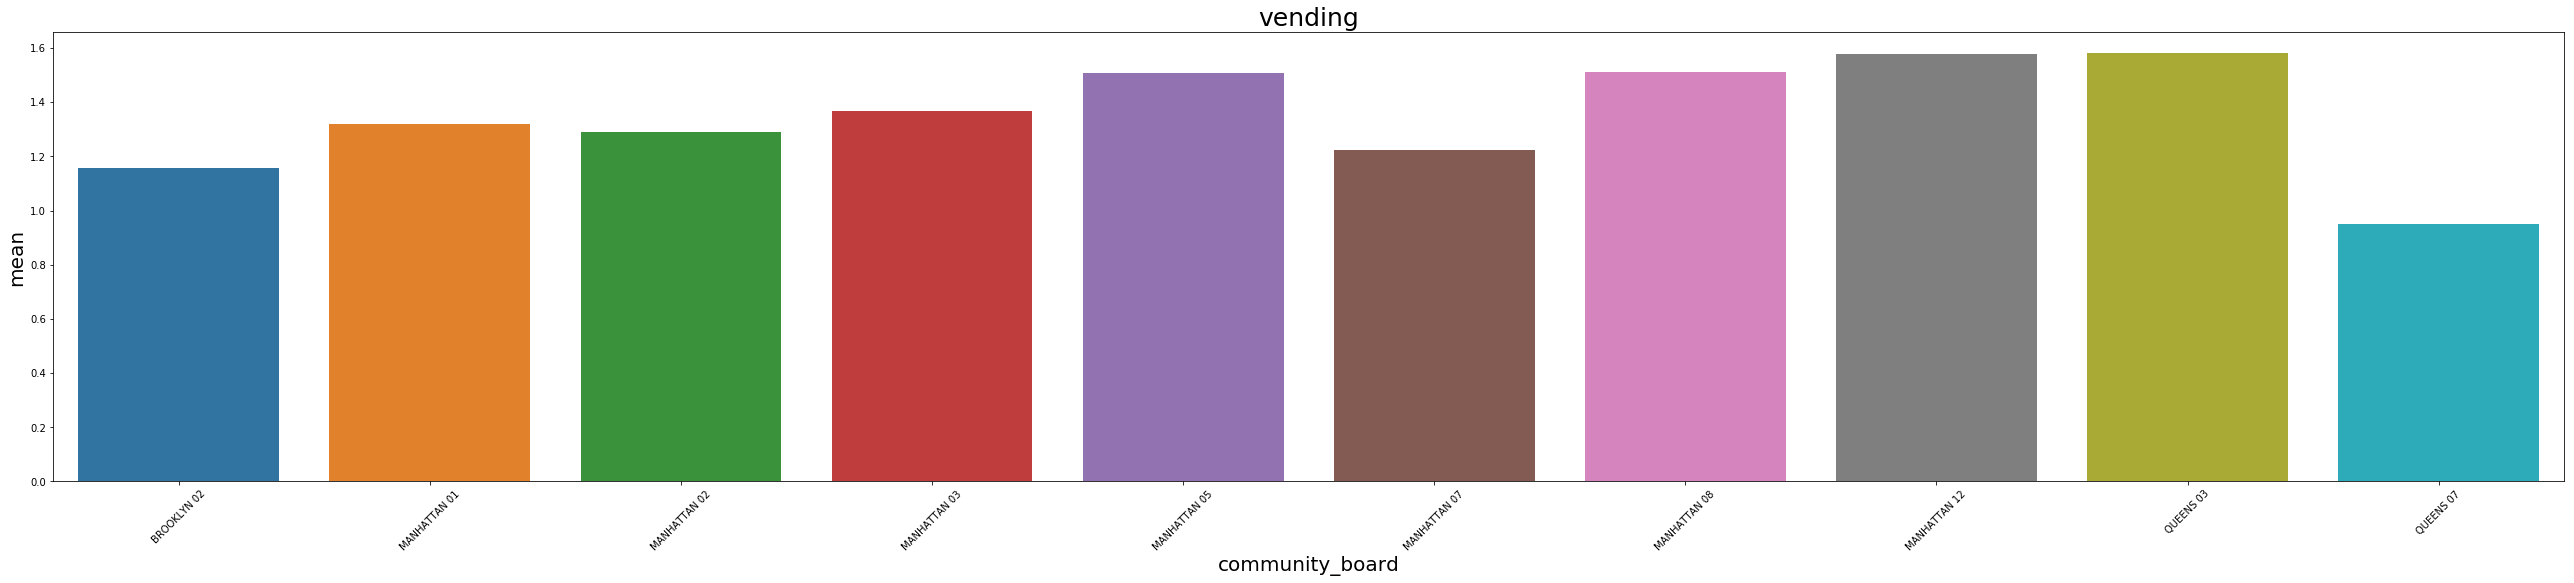

In [129]:
#visually breaks down agency performance by board - log
x= 'community_board'
y= 'mean'
a4_dims = (45, 8.27)




for i in range(len(nypd_complaint_list)):
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.set_title(nypd_complaint_list[i], fontsize=25)
    ax.set_xlabel("Community Board",fontsize=20)
    ax.set_ylabel("Log Mean Completion Time",fontsize=20)
    agencyboardplot = sns.barplot(x, y, data=nypd_complaints[i], ax=ax)
    agencyboardplot.set_xticklabels(agencyboardplot.get_xticklabels(), rotation=45)

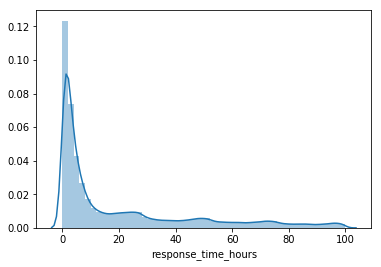

In [130]:
#visualize distribution of complaints resolved between 0 and 100 hours
sns.distplot(db[(db.response_time_hours>0) & (db.response_time_hours<100)].response_time_hours)

In [131]:
#analyzing complaints that took more than 100 hours to solve

hundo = db[db.response_time_hours>100]

In [132]:
agency_list = ['NYPD','HPD','DOT','DOF','DSNY','DEP','DPR','DOB','DOF','DOHMH','DHS','TLC']


hundo['complaint_type'].value_counts()

hundo_grouped = hundo.groupby(['agency','complaint_type'])
hundo_grouped = hundo_grouped.response_time_hours.agg(['mean', 'median', 'std', 'count']).sort_values(by = ['agency', 'mean'], ascending = False)
hundo_grouped = hundo_grouped[hundo_grouped['count'] >200]
hundo_grouped = hundo_grouped.reset_index()
hundo_grouped = hundo_grouped.query('agency in @agency_list')

In [133]:
nypd_hundo = hundo_grouped[hundo_grouped['agency']=='NYPD'].sort_values(by='complaint_type')
hpd_hundo = hundo_grouped[hundo_grouped['agency']=='HPD'].sort_values(by='complaint_type')
dot_hundo = hundo_grouped[hundo_grouped['agency']=='DOT'].sort_values(by='complaint_type')
dsny_hundo = hundo_grouped[hundo_grouped['agency']=='DSNY'].sort_values(by='complaint_type')
dep_hundo = hundo_grouped[hundo_grouped['agency']=='DEP'].sort_values(by='complaint_type')
dpr_hundo = hundo_grouped[hundo_grouped['agency']=='DPR'].sort_values(by='complaint_type')
dob_hundo = hundo_grouped[hundo_grouped['agency']=='DOB'].sort_values(by='complaint_type')
dof_hundo = hundo_grouped[hundo_grouped['agency']=='DOF'].sort_values(by='complaint_type')
dohmh_hundo = hundo_grouped[hundo_grouped['agency']=='DOHMH'].sort_values(by='complaint_type')
tlc_hundo = hundo_grouped[hundo_grouped['agency']=='TLC'].sort_values(by='complaint_type')

agency_list = [nypd_hundo,hpd_hundo,dot_hundo,dsny_hundo,dep_hundo,dpr_hundo,dob_hundo,dof_hundo,dohmh_hundo,tlc_hundo]

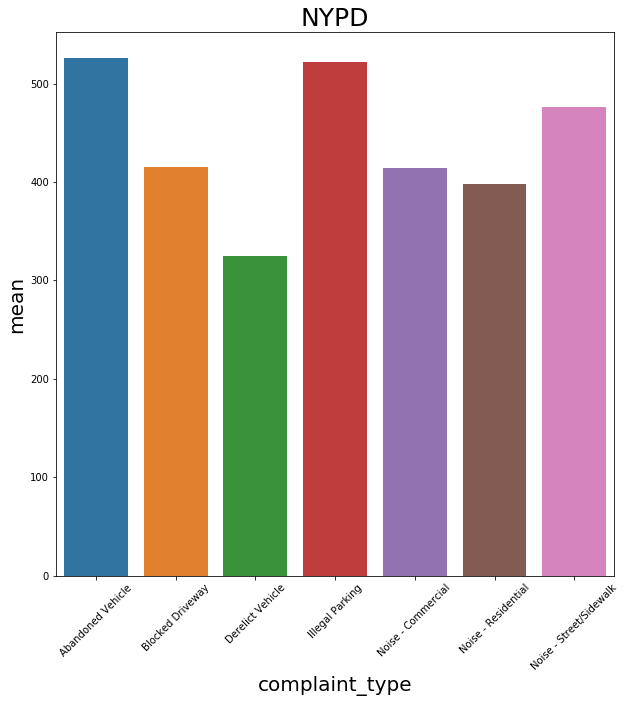

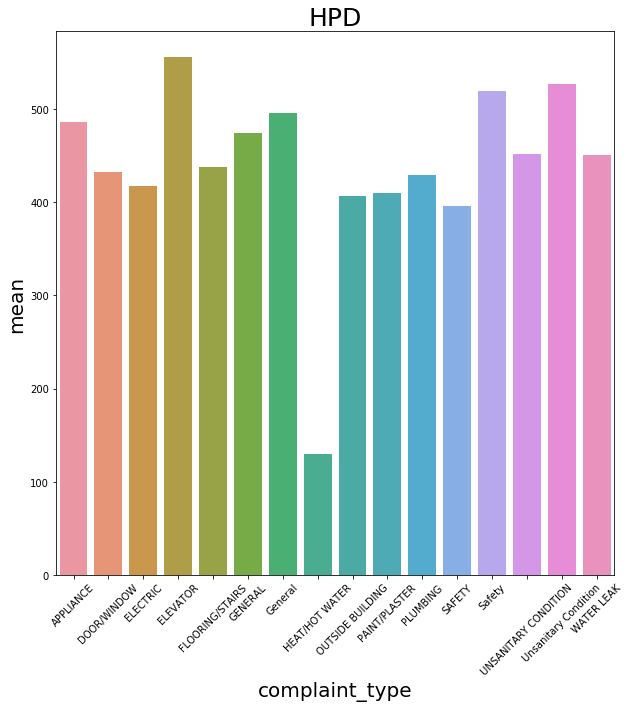

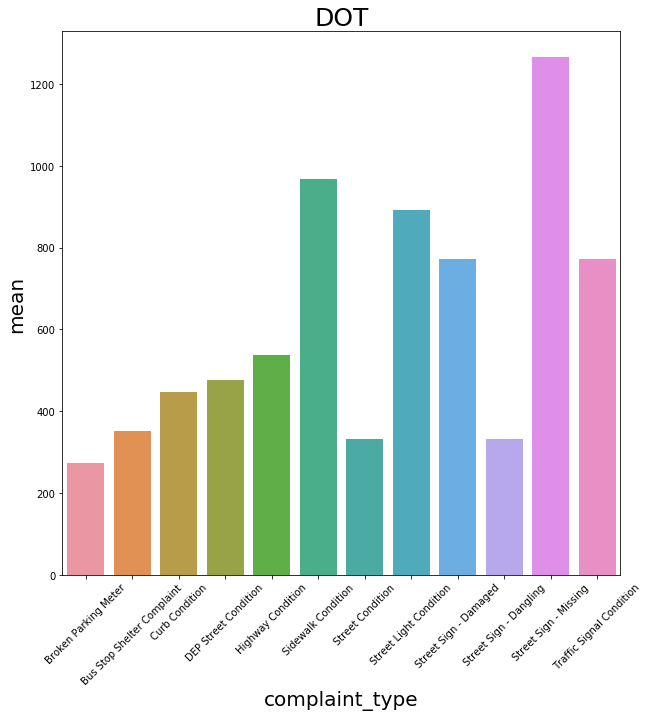

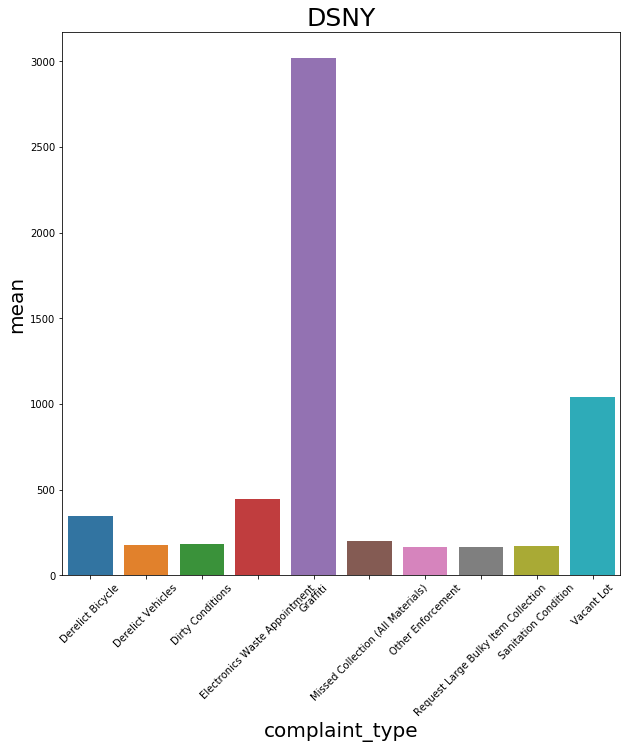

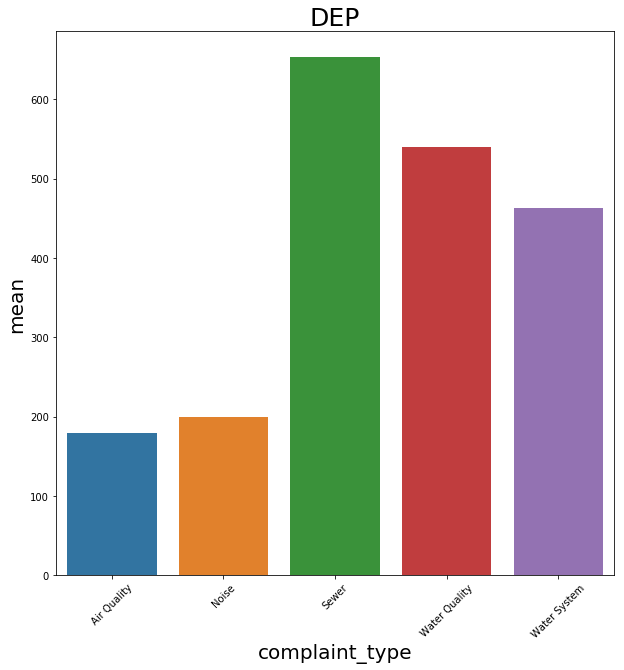

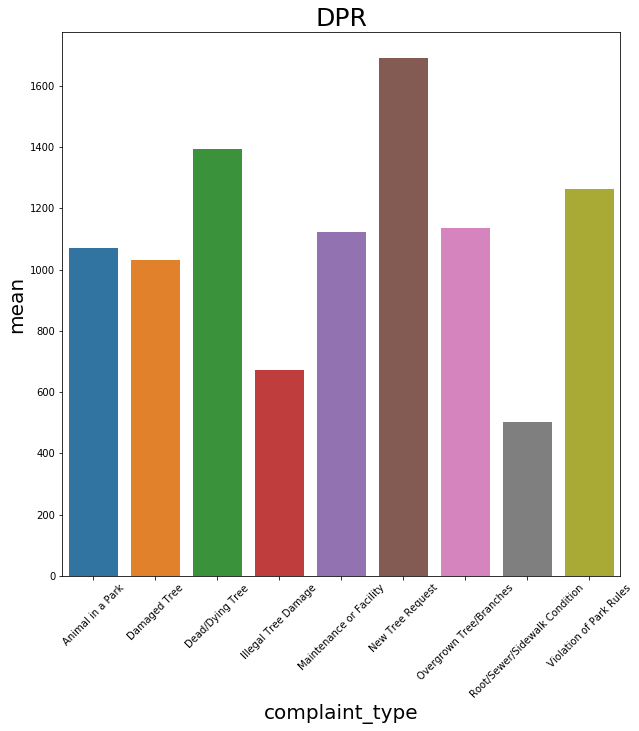

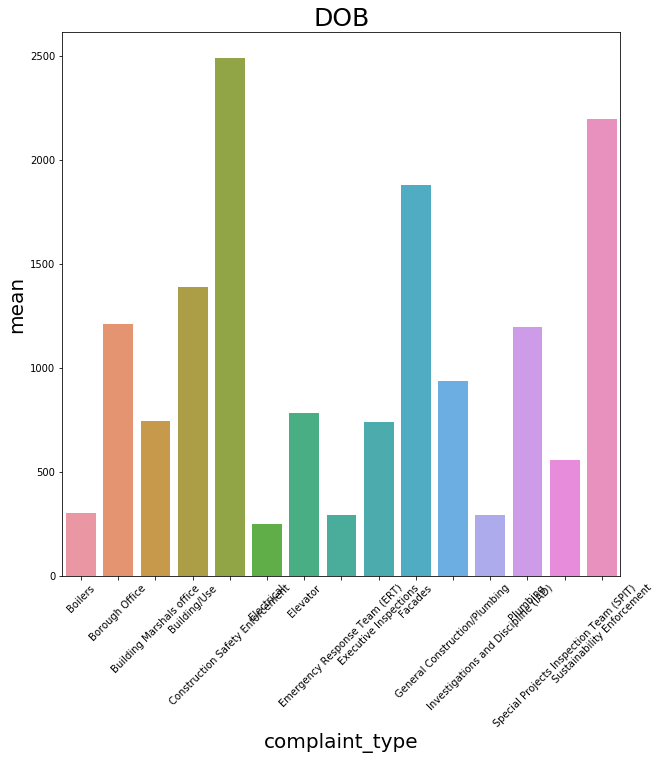

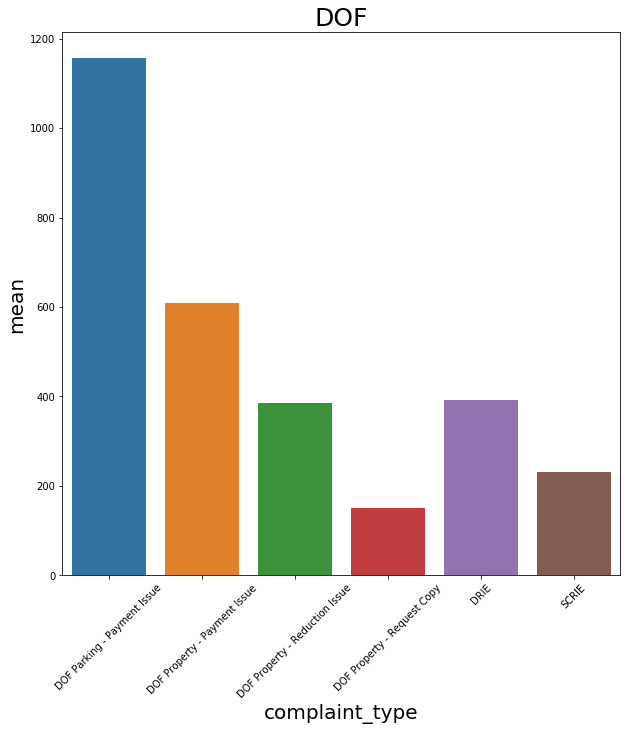

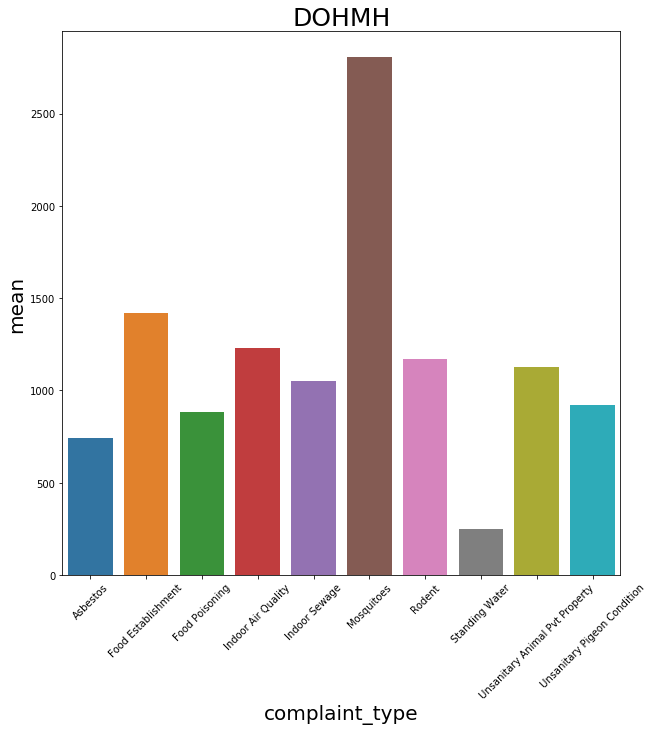

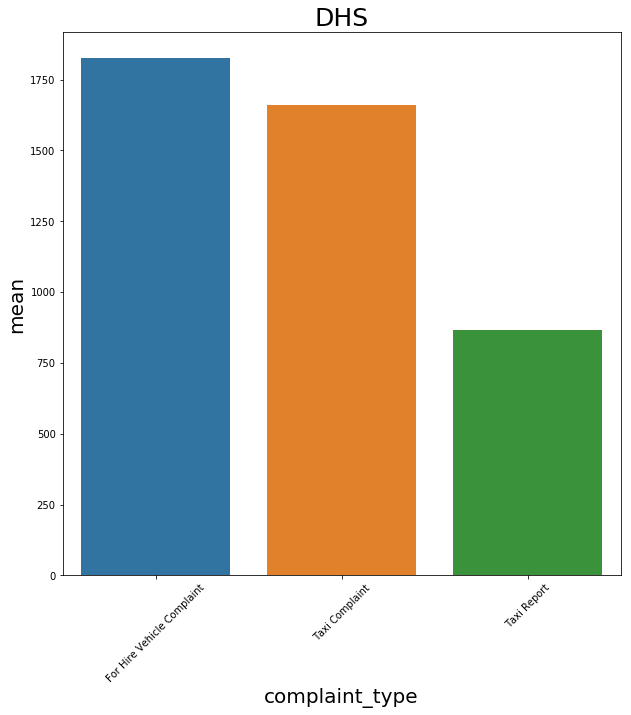

In [134]:
#visually breaks down complaints that take more than 100 hours to resolve by agency
x= 'complaint_type'
y= 'mean'
a4_dims = (10, 10)

for i in range(len(agency_list)):
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.set_title(agency_name_list[i], fontsize=25)
    ax.set_xlabel("Complaint Type",fontsize=20)
    ax.set_ylabel("Mean Completion Time",fontsize=20)
    hundoboardplot = sns.barplot(x, y, data=agency_list[i], ax=ax)
    hundoboardplot.set_xticklabels(hundoboardplot.get_xticklabels(), rotation=45)


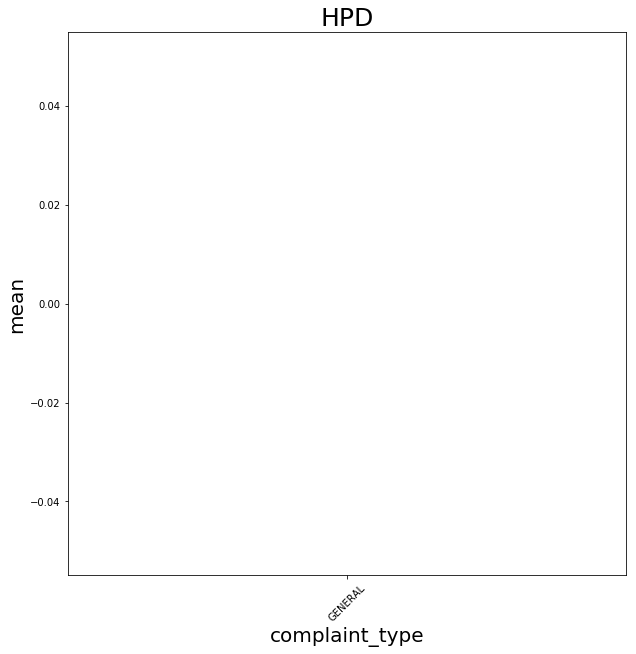

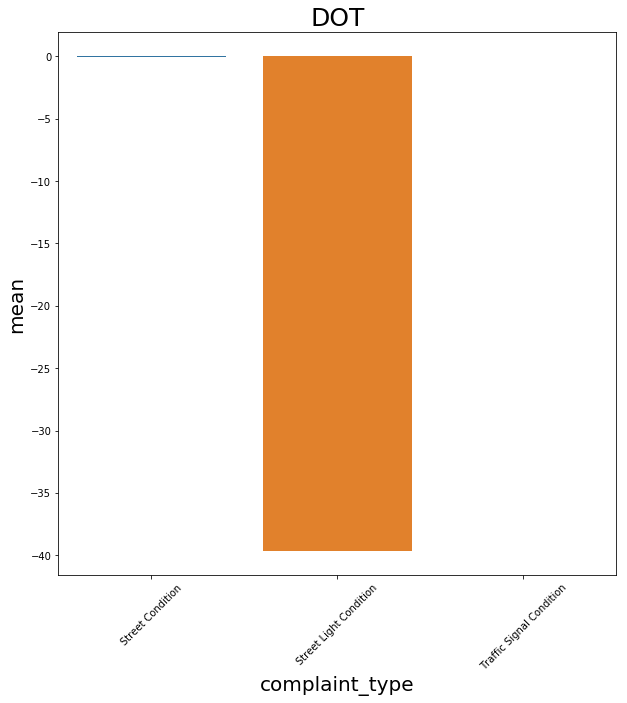

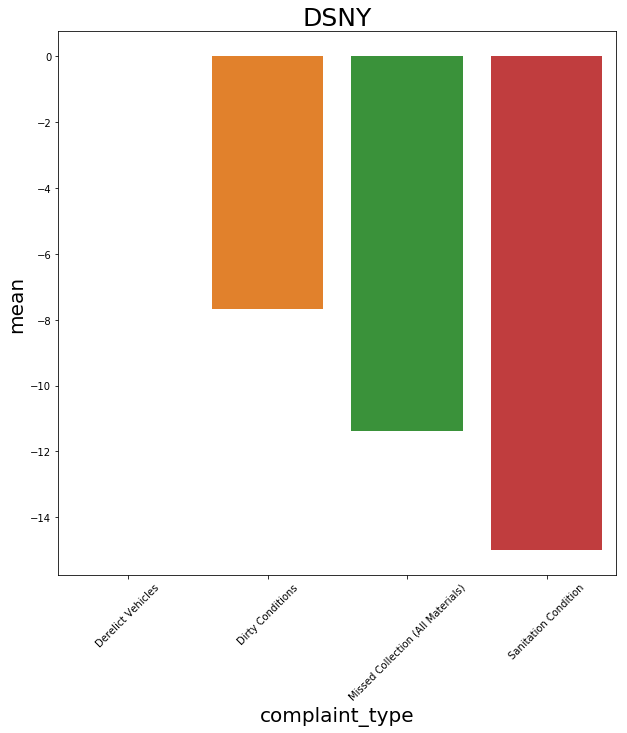

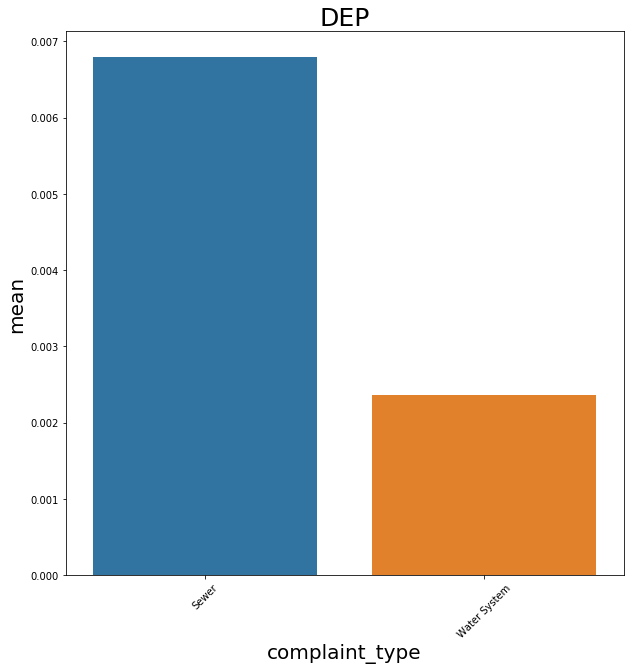

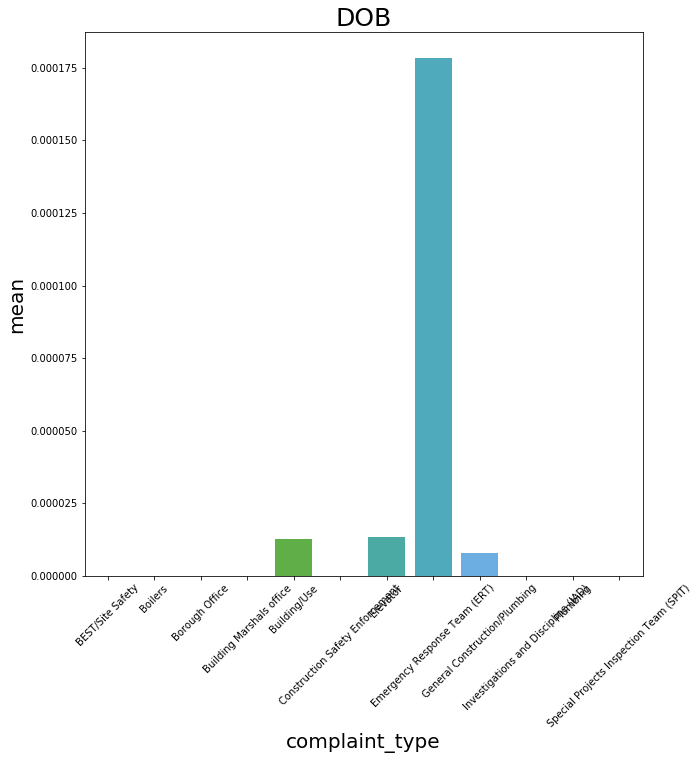

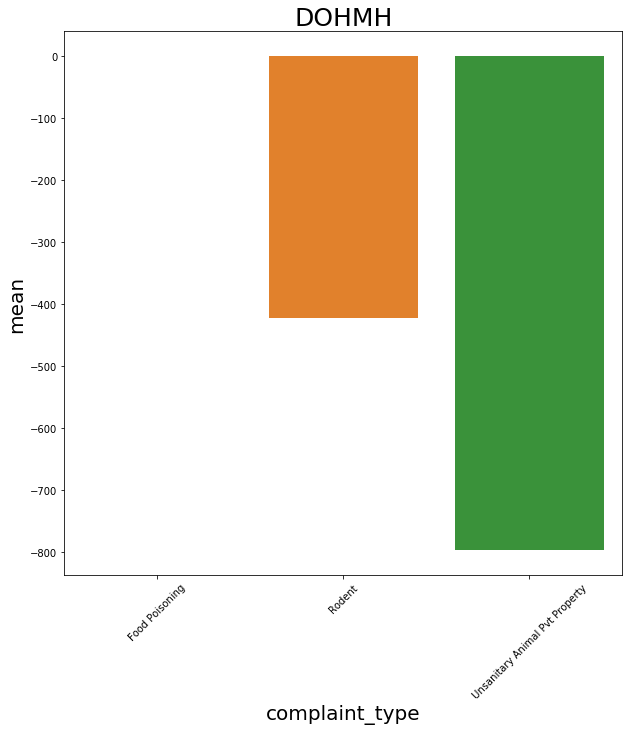

In [135]:
# analyze complaints resolved in under 120 seconds

under2 = db[db.under_120 == 1]

under2_grouped = under2.groupby(['agency','complaint_type'])
under2_grouped = under2_grouped.response_time_hours.agg(['mean', 'median', 'std', 'count']).sort_values(by = ['agency', 'mean'], ascending = False)
under2_grouped = under2_grouped[under2_grouped['count'] >200]
under2_grouped = under2_grouped.reset_index()



hpd_under2 = under2_grouped[under2_grouped['agency']=='HPD'].sort_values(by='complaint_type')
dot_under2 = under2_grouped[under2_grouped['agency']=='DOT'].sort_values(by='complaint_type')
dsny_under2 = under2_grouped[under2_grouped['agency']=='DSNY'].sort_values(by='complaint_type')
dep_under2 = under2_grouped[under2_grouped['agency']=='DEP'].sort_values(by='complaint_type')
dob_under2 = under2_grouped[under2_grouped['agency']=='DOB'].sort_values(by='complaint_type')
dohmh_under2 = under2_grouped[under2_grouped['agency']=='DOHMH'].sort_values(by='complaint_type')
tlc_under2 = under2_grouped[under2_grouped['agency']=='TLC'].sort_values(by='complaint_type')

under_agency_name_list = ['HPD','DOT','DSNY','DEP','DOB','DOHMH']


under_agency_list = [hpd_under2,dot_under2,dsny_under2,dep_under2,dob_under2,dohmh_under2]

#visually breaks down agency performance by board
x= 'complaint_type'
y= 'mean'
a4_dims = (10, 10)

for i in range(len(under_agency_name_list)):
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.set_title(under_agency_name_list[i], fontsize=25)
    ax.set_xlabel("Complaint Type",fontsize=20)
    ax.set_ylabel("Mean Completion Time",fontsize=20)
    underbarplots = sns.barplot(x, y, data=under_agency_list[i], ax=ax)
    underbarplots.set_xticklabels(underbarplots.get_xticklabels(), rotation=45)

In [136]:
#A look at all complaint types with at least 200 complaints

db_grouped = db.groupby(['agency', 'complaint_type'])
db_grouped = db_grouped.response_time_hours.agg(
    ['mean','median','std','count', 'min', 'max']
).sort_values(by = ['agency', 'std'],ascending=False)
db_grouped = db_grouped[db_grouped['count']>200]

In [137]:
db_as_df = db_grouped.reset_index()

In [138]:
# determining complaint types' percentage of total

complaint_types = list(db['complaint_type'].unique())


complaint_values = []
for i in range(len(complaint_types)):
    x = round(len(db[db['complaint_type']==complaint_types[i]])/len(db),2)
    complaint_values.append(x)
    
#results in scalar, makes making a dataframe more difficult    
#complaint_rates = dict(zip(complaint_types, complaint_values))
complaint_rates_as_df =  pd.DataFrame(
    {'Complaint': complaint_types,
     'Percentage': complaint_values
    })
    

In [139]:
complaint_rates_as_df = complaint_rates_as_df.sort_values(by='Percentage', ascending=False).reset_index()

In [140]:
#grab the top 50 complaints by percentage of total complaints
top_complaints = list(complaint_rates_as_df['Complaint'][:50])

In [141]:
#grab the response times associated with top 50 most common complaints

complaint_times = [list([]) for _ in range(len(top_complaints))]

for i in range(len(top_complaints)):
    complaint_times[i].append(
        np.array(db[db['complaint_type']==top_complaints[i]]['response_time_hours']))
    complaint_times[i] = complaint_times[i][0]
    


In [142]:
#remove nulls
def no_nulls(nested_list):
    for lst in range(len(nested_list)):
        nested_list[i] = [x for x in nested_list[i] if x==x]
    return nested_list

complaint_times = no_nulls(complaint_times)

In [143]:
from scipy.stats import iqr
from scipy.stats import zscore

#get z-scores for complaint times
def get_zscores(lst):
    zscore_lst = []
    for i in range(len(lst)):
        zscore_lst.append(zscore(lst[i]))
    return zscore_lst

zscores = get_zscores(complaint_times)
zscores_lists = [array.tolist() for array in zscores]
zscore_flat_list = [item for sublist in zscores_lists for item in sublist]


In [144]:
#create dataframe with zscores and iqr of zscores 

dist_df = pd.DataFrame({'Type': top_complaints, 'Times': complaint_times, 'ZScores': zscores})

iqr_zscores = [iqr(i) for i in zscores]
        
dist_df['iqr_zscore'] = iqr_zscores

In [145]:
# create a new dataframe combining all instances of a complaint type's appearance, the iqr_zscore for the complaint
#type, the time for that individual complaint, and the zscore for the individual complaint
dist_df_spread  = dist_df
Time = dist_df_spread.apply(lambda x: pd.Series(x['Times']),axis=1).stack().reset_index(level=1, drop=True)
Time.name = 'Time'
dist_df_spread = dist_df_spread.drop(['Times', 'ZScores'], axis=1).join(Time)

dist_df_spread['zscore'] = zscore_flat_list
dist_df_spread

,Type,iqr_zscore,Time,zscore
0,Noise - Residential,0.084979,2.371389,-0.086263
0,Noise - Residential,0.084979,2.350278,-0.086684
0,Noise - Residential,0.084979,6.978611,0.005540
0,Noise - Residential,0.084979,5028.215556,100.058903
0,Noise - Residential,0.084979,2.301111,-0.087664
0,Noise - Residential,0.084979,0.680833,-0.119949
0,Noise - Residential,0.084979,1.968889,-0.094283
0,Noise - Residential,0.084979,6.928333,0.004539
0,Noise - Residential,0.084979,3.302500,-0.067710
0,Noise - Residential,0.084979,0.823333,-0.117110


In [146]:
#export for visual analysis in R (see R script in repo)

dist_df_spread.to_csv('2019_complaint_zscore_spread.csv')

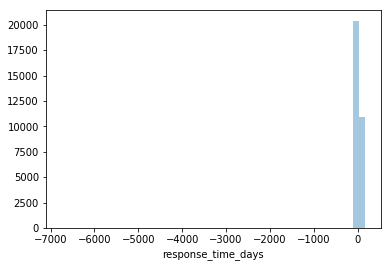

In [147]:
#quick visual of rodent response times
sns.distplot(db[db['complaint_type']=='Rodent']['response_time_days'], kde=False)

In [148]:
#analyze lead complaint resolutions
lead = db[db['complaint_type']=='Lead']
lead['resolution_description'].value_counts()

the department of environmental protection investigated this complaint and created a service request to have a lead test kit sent to the complainant.                                                                                                                                                                                     8713
the department of environmental protection did not observe a violation of the new york city air/noise code at the time of inspection and could not issue a notice of violation. if the problem still exists, please call 311 and file a new complaint. if you are outside of new york city, please call (212) new-york (212-639-9675).       1
the department of environment protection inspected your complaint but could not find the problem you reported. if the condition persists, please call 311 (or 212-639-9675 if calling from a non-new york city area code) with more detailed information to submit a new complaint.                                                       

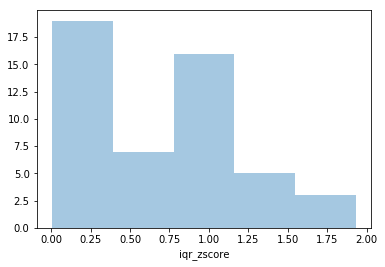

In [149]:
#plot iqrs of zscores
sns.distplot(dist_df['iqr_zscore'], kde=False)

In [150]:
print('iqr of iqrs: ', iqr(dist_df.iqr_zscore), '\n'
      'mean of iqrs: ', dist_df.iqr_zscore.mean(), '\n'
      'max: ', dist_df.iqr_zscore.max(), '\n'
      'min: ', dist_df.iqr_zscore.min())


iqr of iqrs:  0.8876088035548851 
mean of iqrs:  0.6620167258277796 
max:  1.9328725892248761 
min:  0.004740589141938367


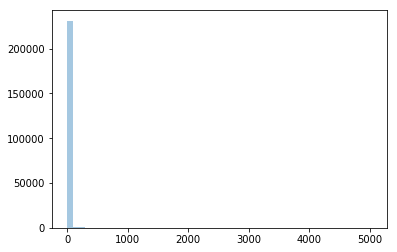

In [151]:
sns.distplot(dist_df['Times'][0], kde=False)

0.0849790208775215


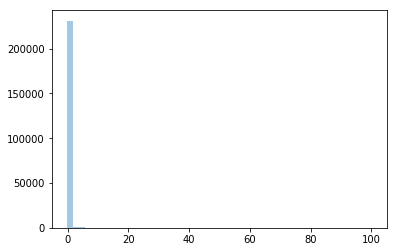

In [152]:
print(dist_df.iqr_zscore[0])
sns.distplot(dist_df.ZScores[0], kde=False)

In [153]:
#determine how many duplicate cases for consumer complaints with response time less than 5 days

db[(db['complaint_type']=='Consumer Complaint')&(db['response_time_days']<5)].res_desc.value_counts()


ongoing            3678
no_action_taken    2386
wrong_agency       1025
string              772
ambiguous            20
Name: res_desc, dtype: int64

In [154]:
#seeing duplicates as a percentage of all "consumer complaint" complaints addressed in under 5 days
len(db[(db.complaint_type == "Consumer Complaint")&(db['response_time_days']<5)&(db.res_desc == "duplicate")])/len(db[(db['complaint_type']=='Consumer Complaint')&(db['response_time_days']<5)])

0.0

In [155]:
db[(db['complaint_type']=='Consumer Complaint')&(db['response_time_hours']<200)].res_desc.value_counts()

ongoing            3694
no_action_taken    2400
wrong_agency       1038
string              775
ambiguous            20
Name: res_desc, dtype: int64

did_not_observe    3484
fixed              2970
wrong_agency         45
duplicate            32
string                1
Name: res_desc, dtype: int64 1 Missed Collection                  2120
1R Missed Recycling-All Materials    1169
2 Bulk-Missed Collection              964
2R Bulk-Missed Recy Collection        634
1RB Missed Recycling - M/G/Pl         610
1RG Missed Recycling Paper            571
1RO Missed Recycling Organics         445
1C Uncollected Xmas Trees              10
1L Missed Recycling Leaves              9
Name: descriptor, dtype: int64 01 STATEN ISLAND      1397
12 QUEENS              606
03 STATEN ISLAND       584
01 BROOKLYN            518
07 QUEENS              336
13 QUEENS              315
18 BROOKLYN            300
02 STATEN ISLAND       296
12 BROOKLYN            270
06 BROOKLYN            169
14 QUEENS              162
15 BROOKLYN            124
05 BROOKLYN            123
11 QUEENS              121
10 BRONX               108
08 QUEENS               97
10 MANHATT

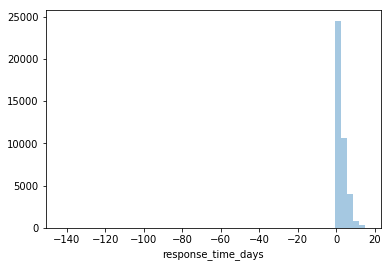

In [156]:
#a summary of results related to the complaint "missed collection (all materials)"
print(db[(db['complaint_type']=='Missed Collection (All Materials)')&(db['response_time_days']>5)].res_desc.value_counts(),
      db[(db['complaint_type']=='Missed Collection (All Materials)')&(db['response_time_days']>5)].descriptor.value_counts(),
      db[(db['complaint_type']=='Missed Collection (All Materials)')&(db['response_time_days']>5)]['community_board'].value_counts(),
      db[(db['complaint_type']=='Missed Collection (All Materials)')&(db['response_time_days']<5)].res_desc.value_counts(),
      db[(db['complaint_type']=='Missed Collection (All Materials)')&(db['response_time_days']<5)].descriptor.value_counts(),
      db[(db['complaint_type']=='Missed Collection (All Materials)')&(db['response_time_days']<5)]['community_board'].value_counts())
sns.distplot(db[
    (db['complaint_type']=='Missed Collection (All Materials)')&
    (db['response_time_days']<15)].response_time_days, kde=False)

In [157]:
#create missed collection complaint df, aggregate by count
missed_collection = db[db['complaint_type']=='Missed Collection (All Materials)']
missed_collection['five_and_up'] = missed_collection.response_time_days >=5
missed_collection_grouped  = missed_collection.groupby(['community_board', 'five_and_up'])
missed_collection_grouped = missed_collection_grouped.response_time_days.aggregate('count').to_frame().reset_index()
missed_collection_grouped = missed_collection_grouped[missed_collection_grouped.five_and_up == True]


missed_collection_grouped_2 = missed_collection.groupby('community_board')
missed_collection_grouped_2 = missed_collection_grouped_2.response_time_days.aggregate('count').to_frame().reset_index()

/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [158]:
#group and sort for missed collection complaint
     
missed_collection_grouped = missed_collection_grouped.sort_values('community_board')
missed_collection_grouped_2 = missed_collection_grouped_2.sort_values('community_board')

In [159]:
#join the frames to show the total number of missed collection complaints by community board, 
#number of complaints that took more than 5 days, and that  percent of total

missed_collection_total = missed_collection_grouped.join(missed_collection_grouped_2.set_index("community_board"), on='community_board', lsuffix = '_l', rsuffix = '_r')
missed_collection_total = missed_collection_total.rename(columns = {'response_time_days_l': 'count_over_5', 'response_time_days_r': 'total'})
missed_collection_total = missed_collection_total.drop(['five_and_up'], axis=1)
missed_collection_total['five_up_rate'] = round(missed_collection_total.count_over_5/missed_collection_total.total,2)
missed_collection_total.sort_values(by = ['five_up_rate', 'count_over_5'])



,community_board,count_over_5,total,five_up_rate
106,14 BROOKLYN,2,868,0.00
31,04 BRONX,1,88,0.01
90,11 MANHATTAN,1,153,0.01
120,Unspecified QUEENS,1,90,0.01
37,04 QUEENS,2,291,0.01
84,10 QUEENS,8,1012,0.01
51,06 MANHATTAN,5,209,0.02
15,02 MANHATTAN,8,334,0.02
66,08 MANHATTAN,8,379,0.02
56,07 BROOKLYN,13,531,0.02


fixed              242
no_action_taken     12
ambiguous            5
did_not_observe      3
wrong_agency         1
Name: res_desc, dtype: int64 No Parking, Standing, Stopping    140
Other/Unknown                      57
Street Cleaning - ASP              48
Construction                       10
Speed Limit                         3
St Name - Attached to Pole          2
Bus Stop                            1
Stop                                1
Detour                              1
Name: descriptor, dtype: int64 02 QUEENS           25
07 QUEENS           22
14 QUEENS           21
01 QUEENS           16
08 QUEENS           15
05 QUEENS           14
01 BROOKLYN         13
12 QUEENS           11
06 BROOKLYN         10
18 BROOKLYN          9
17 BROOKLYN          9
05 BROOKLYN          7
09 QUEENS            6
06 QUEENS            6
13 QUEENS            6
0 Unspecified        6
04 BROOKLYN          5
11 BROOKLYN          4
03 QUEENS            4
15 BROOKLYN          4
13 BROOKLYN          3


AttributeError: 'tuple' object has no attribute 'set'

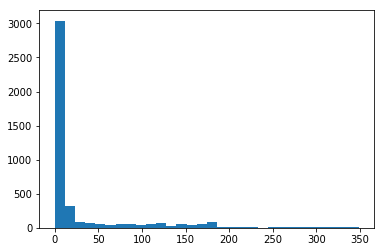

In [160]:
#summary of data on missing street signs

print(db[(db['complaint_type']=='Street Sign - Missing')&(db['response_time_days']>160)].res_desc.value_counts(),
db[(db['complaint_type']=='Street Sign - Missing')&(db['response_time_days']>160)].descriptor.value_counts(),
db[(db['complaint_type']=='Street Sign - Missing')&(db['response_time_days']>160)]['community_board'].value_counts(),
db[(db['complaint_type']=='Street Sign - Missing')&(db['response_time_days']<160)].res_desc.value_counts(),
db[(db['complaint_type']=='Street Sign - Missing')&(db['response_time_days']<160)].descriptor.value_counts(),
db[(db['complaint_type']=='Street Sign - Missing')&(db['response_time_days']<160)]['community_board'].value_counts())


ax = plt.hist(db[db['complaint_type']=='Street Sign - Missing'].response_time_days, bins = 30)
ax.set(xlabel='Num Days to Close', ylabel='Num Complaints')
plt.title("Missing Street Signs", fontsize=20)
plt.show()
ax

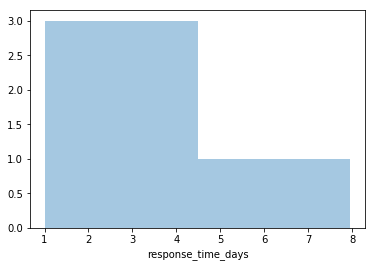

In [161]:
#analyzing electronics waste complaints that took less thanh 1000 hours, represented as days (~ <45)
sns.distplot(db[(db['complaint_type']=='Electronics Waste')&(db['response_time_hours']<1000)].response_time_days, kde=False)

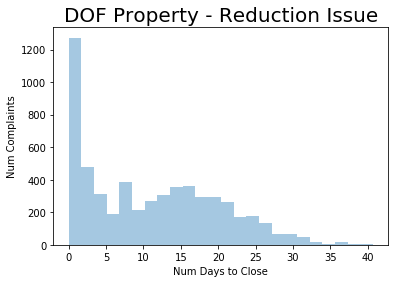

In [162]:
#begin analysis of complaint: 'DOF Property - Reduction Issue'

ax = sns.distplot(
    db[(db['complaint_type']=='DOF Property - Reduction Issue')&
       (db['response_time_hours']<1000)]['response_time_days'], kde=False)
ax.set(xlabel='Num Days to Close', ylabel='Num Complaints')
plt.title("DOF Property - Reduction Issue", fontsize=20)
plt.show()



In [163]:
# 'DOF Property - Reduction Issue' resolution summary
print(
    db[(db['complaint_type']=='DOF Property - Reduction Issue')&
    (db['response_time_hours']<1000)&
    (db['response_time_hours']>700)]['resolution_description'].value_counts(),
    db[(db['complaint_type']=='DOF Property - Reduction Issue')&
       (db['response_time_hours']<700)]['resolution_description'].value_counts())

see notes.                                                                            131
the department of finance determined that you are not eligible for this reduction.      1
Name: resolution_description, dtype: int64 see notes.                                                                                                                                  5340
the department of finance determined that you are not eligible for this reduction.                                                           109
the department of finance granted this reduction.                                                                                             94
the department of finance was unable to resolve the issue as it requires additional information.                                              25
the department of finance did not receive an application for this reduction. they mailed you a blank application to complete and return.      19
Name: resolution_description, dtype: int64


fixed              787
did_not_observe    412
no_action_taken    201
string              12
Name: res_desc, dtype: int64 Branch or Limb Has Fallen Down    574
Branch Cracked and Will Fall      407
Tree Alive - in Poor Condition    220
Tree Leaning/Uprooted              96
Entire Tree Has Fallen Down        93
Tree Trunk Split                   22
Name: descriptor, dtype: int64 15 BROOKLYN             114
11 QUEENS                78
10 BROOKLYN              68
18 BROOKLYN              67
13 QUEENS                63
12 BROOKLYN              59
14 BROOKLYN              56
02 STATEN ISLAND         51
03 STATEN ISLAND         49
11 BROOKLYN              46
07 BROOKLYN              45
07 QUEENS                44
01 QUEENS                41
03 BROOKLYN              37
01 STATEN ISLAND         37
05 BROOKLYN              36
09 BROOKLYN              36
08 QUEENS                36
06 BROOKLYN              35
05 QUEENS                33
12 QUEENS                30
08 BROOKLYN              28
04 B

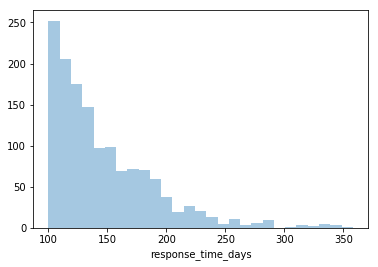

In [164]:
#damaged tree summary

print(db[(db['complaint_type']=='Damaged Tree')&(db['response_time_days']>100)].res_desc.value_counts(),
      db[(db['complaint_type']=='Damaged Tree')&(db['response_time_days']>100)].descriptor.value_counts(),
      db[(db['complaint_type']=='Damaged Tree')&(db['response_time_days']>100)]['community_board'].value_counts(),
      db[(db['complaint_type']=='Damaged Tree')&(db['response_time_days']<100)].res_desc.value_counts(),
      db[(db['complaint_type']=='Damaged Tree')&(db['response_time_days']<100)].descriptor.value_counts(),
      db[(db['complaint_type']=='Damaged Tree')&(db['response_time_days']<100)]['community_board'].value_counts())
      
sns.distplot(db[(db['complaint_type']=='Damaged Tree')&(db['response_time_days']>100)].response_time_days, kde=False)

In [165]:
#analyze complaint responses and resolution times regarding rodents

rats = data_orig[data_orig['complaint_type']=='Rodent']
print(rats['response_time_hours'].median(),
      dist_df_spread[dist_df_spread['Type'] == 'Rodent']['Time'].mean())
rats['response_time_days'] = [i.total_seconds()/86400.0 for i in rats['response_time']]


#percent of rodent complaints that are solved in negative time
len(rats[rats.response_time_hours<=0])/len(rats)



363.09166666666664 828.7585592725188


/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.12090377626797283

In [166]:
rats_grouped = rats.groupby('response_time_days')
rats_grouped = rats_grouped.agency.aggregate('count')
rats_grouped.to_csv('2019_rat_times.csv')

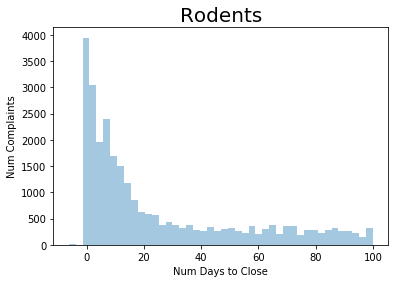

In [167]:
rodents = sns.distplot(rats[(rats.response_time_days>-100)&(rats.response_time_days<100)].response_time_days, kde=False)
rodents.set(xlabel='Num Days to Close', ylabel='Num Complaints')
plt.title("Rodents", fontsize=20)
plt.show()

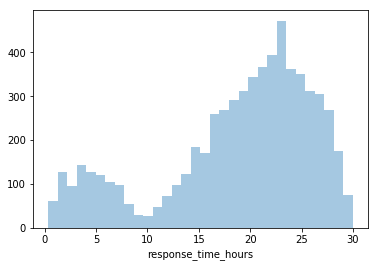

In [168]:
#analyzing led kit responses in less than 30 hours - 
# - it appears an automatic message is sent out exactly 24 hours after the complaint is made
sns.distplot(db[(db['complaint_type']=='Lead')
               &(db.response_time_hours<30)].response_time_hours, kde=False)

In [169]:
signs = db[db['complaint_type']=='Street Sign - Missing']
signs_grouped = signs.groupby('response_time_days')
signs_grouped = signs_grouped.agency.aggregate('count')
signs_grouped.to_csv('2019_signs_times.csv')

In [170]:
db[(db.res_desc == 'ambiguous')&(db.agency == 'DOT')&(db['complaint_type']=='Street Light Condition')]['resolution_description'].value_counts()

service request status for this request is available on the department of transportationâs website. please click the âlearn moreâ link below.    61429
service request status for this request is available on the department of transportation's website. please click the "learn more" link below.           4077
Name: resolution_description, dtype: int64

In [171]:
#which agencies have the greatest number of ambiguous resolutions?
db[db.res_desc == 'ambiguous'].agency.value_counts()

DOT      137928
HPD       53327
NYPD      40265
DOB       20638
DOF       15294
TLC        9988
DEP        4823
DHS        1585
DOHMH        48
DCA          20
Name: agency, dtype: int64

In [172]:
#total DOT ambiguous resolutions as a percentage of all DOT resolutions
len(db[(db.agency=='DOT')&(db.res_desc == "ambiguous")])/len(db[db.agency == 'DOT'])

0.5078892812560988

In [173]:
len(db[(db.res_desc == 'ambiguous')&(db.agency == 'DOT')&(db['complaint_type']=='Street Light Condition')])

65506

In [174]:
db[(db.res_desc == 'ambiguous')&(db.agency == 'DOT')&(db['complaint_type']=='Street Light Condition')].descriptor.value_counts()

Street Light Out                     46673
Lamppost Base Door/Cover Open         3036
Fixture/Luminaire Out Of Position     2220
Street Light Cycling                  1907
Fixture/Luminaire Door Open           1647
Multiple Street Lights Out            1103
Fixture/Luminaire Hanging              962
Street Light Lamp Dim                  798
Lamppost Damaged                       773
Photocell (PEC) Missing                753
Street Light Dayburning                681
Lamppost Wire Exposed                  533
Flood Light Lamp Out                   460
Traffic Signal Light                   435
Lamppost Leaning                       403
Lamppost Knocked Down                  394
Fixture/Luminaire Damaged              382
Lamppost Base Door/Cover Damaged       334
Street Light Lamp Missing              309
Foreign Attachment On Lamppost         263
Lamppost Base Door/Cover Missing       234
Lamppost Missing                       193
Flood Light Lamp Cycling               164
Glassware B

In [175]:
###################################  Top Agency Breakdown  ##############################################################

In [176]:
agency_list_final = ['NYPD','HPD','DSNY','DOT','DEP','DOB','DPR','DOF','DOHMH','TLC']
pattern = '|'.join(agency_list_final)

agencies = db[db.agency.str.contains(pattern)==True]
agencies_grouped = agencies.groupby(['agency','res_desc'])
agencies_grouped = agencies_grouped.descriptor.aggregate(['count']).reset_index()
agencies_grouped.loc[agencies_grouped['res_desc'].str.contains('string'), 'res_desc'] = 'other'
agency_totals = agencies_grouped.groupby('agency')
agency_totals = agency_totals['count'].aggregate('sum').reset_index().rename(columns = {'count': 'total'})
agencies_joined = agencies_grouped.merge(agency_totals, on = 'agency')
agencies_joined['percent_per_agency'] = round(agencies_joined['count']/agencies_joined.total,2)
agencies_joined
agencies_joined.to_csv('2019_agencies_rates.csv')

In [177]:
#breakdown of noise complaints by ones that NYPD responds to vs. ones that DEP responds to
print(
    len(db[(db.agency=='NYPD')&(db['complaint_type'].str.lower().str.contains('noise'))]),
    len(db[(db.agency=='DEP')&(db['complaint_type'].str.lower().str.contains('noise'))])
)

418619 56077


In [178]:
#breakdown of what % of all noise complaints are residential vs. construction noise
noise_total = len(db[db['complaint_type'].str.contains('Noise')])

print(
    round(len(db[db['complaint_type'].str.contains('Residential')]['complaint_type'])/noise_total,3),
    round(len(db[(db.agency=='DEP')&(db['complaint_type'].str.contains('Noise'))])/noise_total,3)
    )

0.487 0.118


In [179]:
#breakdown of what % of DEP complaints are noise-related.
len(db[(db.agency=='DEP')&(db['complaint_type']=='Noise')])/len(db[db.agency=='DEP'])

0.31876602299922124

In [180]:
################################################# Data Requests for 311 Hearing ##############################################

In [181]:
# Top 10 complaints (service request categories),

top_complaints = db['complaint_type'].value_counts().to_frame().reset_index()
top_complaints = top_complaints.rename(columns = {'index': 'complaint_type', 'complaint_type': 'count'})
top_complaints.complaint_type = top_complaints.complaint_type.str.lower()


top_complaints.loc[top_complaints['complaint_type'].str.contains('noise'), 'complaint_type'] = 'all noise'
top_complaints = top_complaints.groupby('complaint_type')
top_complaints = top_complaints.aggregate('sum').sort_values(by='count', ascending=False).reset_index()
top_complaints[:10].to_csv('2019_top_complaints.csv')

In [182]:
# top 10 responding agencies,

top_agencies = db.agency.value_counts().to_frame().reset_index().rename(columns= {'index': 'agency', 'agency': 'number_complaints'})
top_agencies.head()
top_agencies[:10].to_csv('2019_top_agencies.csv')

In [183]:
# Longest response time average by agency and complaint type? 


longest = db[db.response_time_days >0]
longest_grouped = longest.groupby(['agency','complaint_type'])
longest_grouped = longest_grouped.response_time_days.aggregate(['mean', 'count', 'std']).sort_values(by='mean', ascending=False).reset_index()
longest_grouped = longest_grouped[longest_grouped['count']>1000]
longest_grouped = longest_grouped.rename(columns = {'mean': 'mean_days'})
longest_grouped.to_csv('2019_longest_response_time.csv')

In [184]:
# Shortest (not negative) response time average by agency and complaint type?

no_neg = db[db.response_time_days >0]
no_neg_agency = no_neg.groupby(['agency','complaint_type'])
df_no_negs = no_neg_agency.response_time_minutes.aggregate(['mean', 'count', 'std']).sort_values(by='mean').reset_index()
df_no_negs = df_no_negs[df_no_negs['count']>1000]
df_no_negs = df_no_negs.rename(columns = {'mean': 'mean_minutes'})

df_no_negs.to_csv('2019_shortest_response_time.csv')

In [185]:
# DSNY Snow Storm data – responsiveness, closing complaints, geography: look at dates from NOV 2018 Snow Storm and JAN / FEB 2018 Snow Storm; % forwarded or not forwarded that should be forwarded

snow = db[(db.agency=='DSNY')&(db['complaint_type']=='Snow')]
tmp = pd.to_datetime(snow['created_date'])
snow['year'] = tmp.dt.year
snow['month'] = tmp.dt.month
snow['day'] = tmp.dt.day



snow_grouped = snow.groupby('community_board')
snow_grouped = snow_grouped.response_time_days.aggregate(['count', 'mean', 'std']).reset_index()
snow_grouped = snow_grouped[~snow_grouped['community_board'].str.contains("Unspecified")]

snow_borough = snow.groupby('borough')
snow_borough = snow_borough.response_time_days.aggregate(['count', 'mean', 'std']).reset_index()


#define function to reverse order of community board so that borough comes first
def reverseWords(input): 
      
    # split words of string separated by space 
    inputWords = input.split(" ") 
  
    # reverse list of words 
    # suppose we have list of elements list = [1,2,3,4],  
    # list[0]=1, list[1]=2 and index -1 represents 
    # the last element list[-1]=4 ( equivalent to list[3]=4 ) 
    # So, inputWords[-1::-1] here we have three arguments 
    # first is -1 that means start from last element 
    # second argument is empty that means move to end of list 
    # third arguments is difference of steps 
    inputWords=inputWords[-1::-1] 
  
    # now join words with space 
    output = ' '.join(inputWords) 
      
    return output

snow_grouped['community_board'] = [reverseWords(x) for x in snow_grouped['community_board']]
snow_grouped=snow_grouped.sort_values(by='community_board')

/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/bwitte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

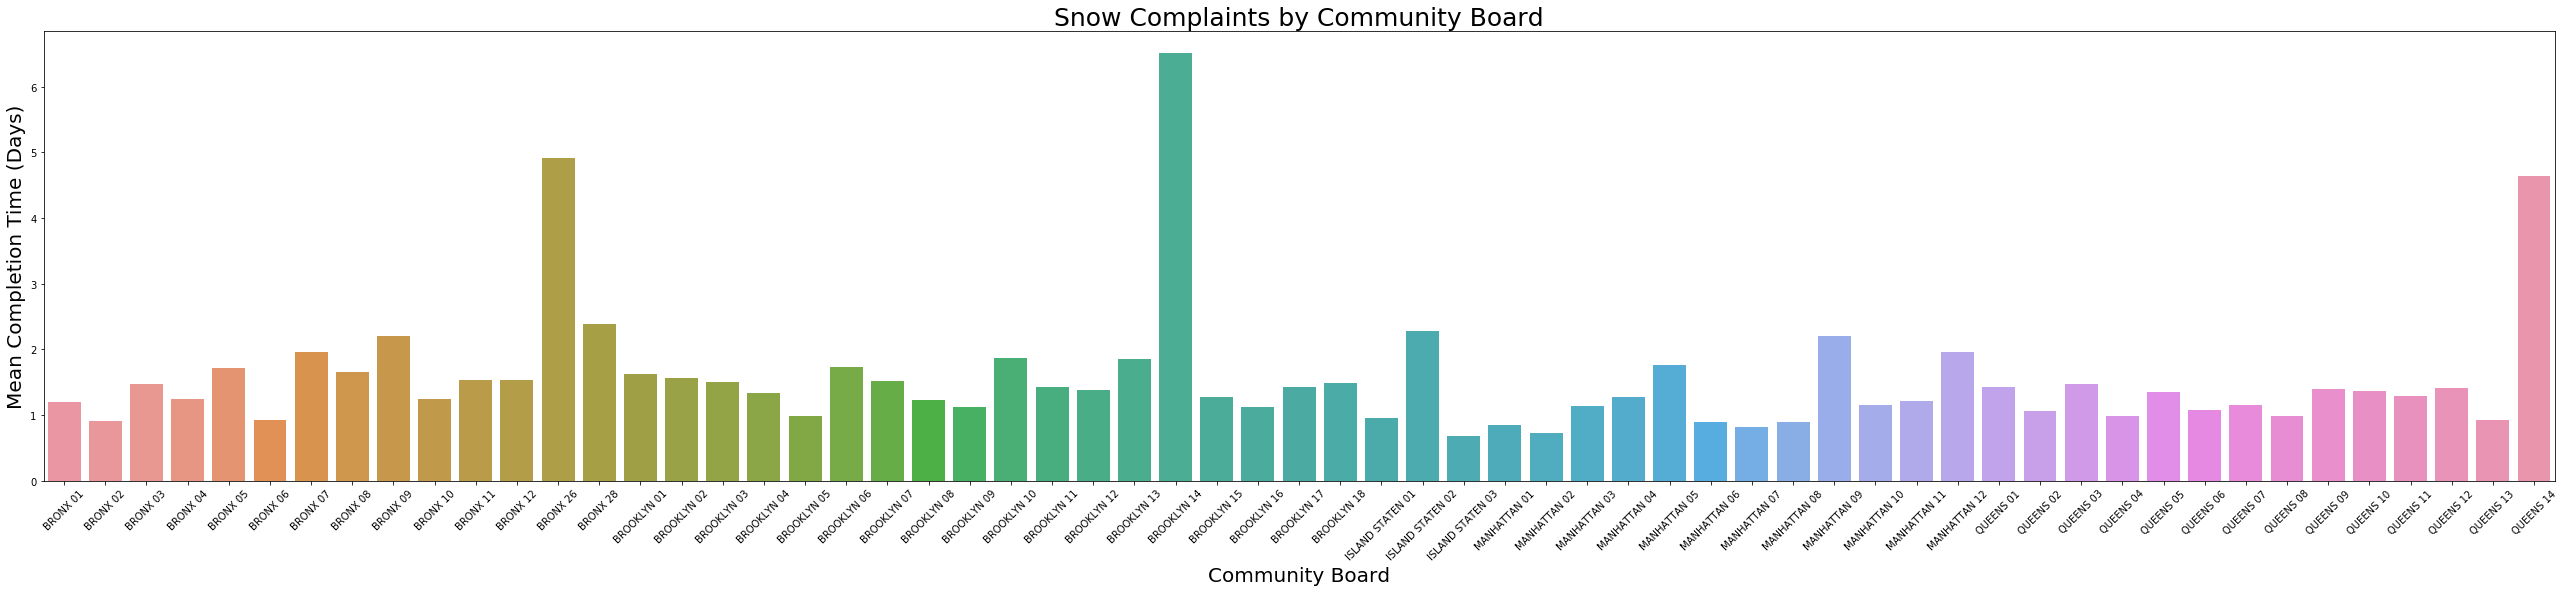

In [186]:
#snow complaints by community board

x= 'community_board'
y= 'mean'



ax = sns.barplot(x, y, data=snow_grouped)
ax.set_title('Snow Complaints by Community Board', fontsize=25)
ax.set_xlabel("Community Board",fontsize=20)
ax.set_ylabel("Mean Completion Time (Days)",fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.gcf().set_size_inches(45, 8.27)
plt.show()

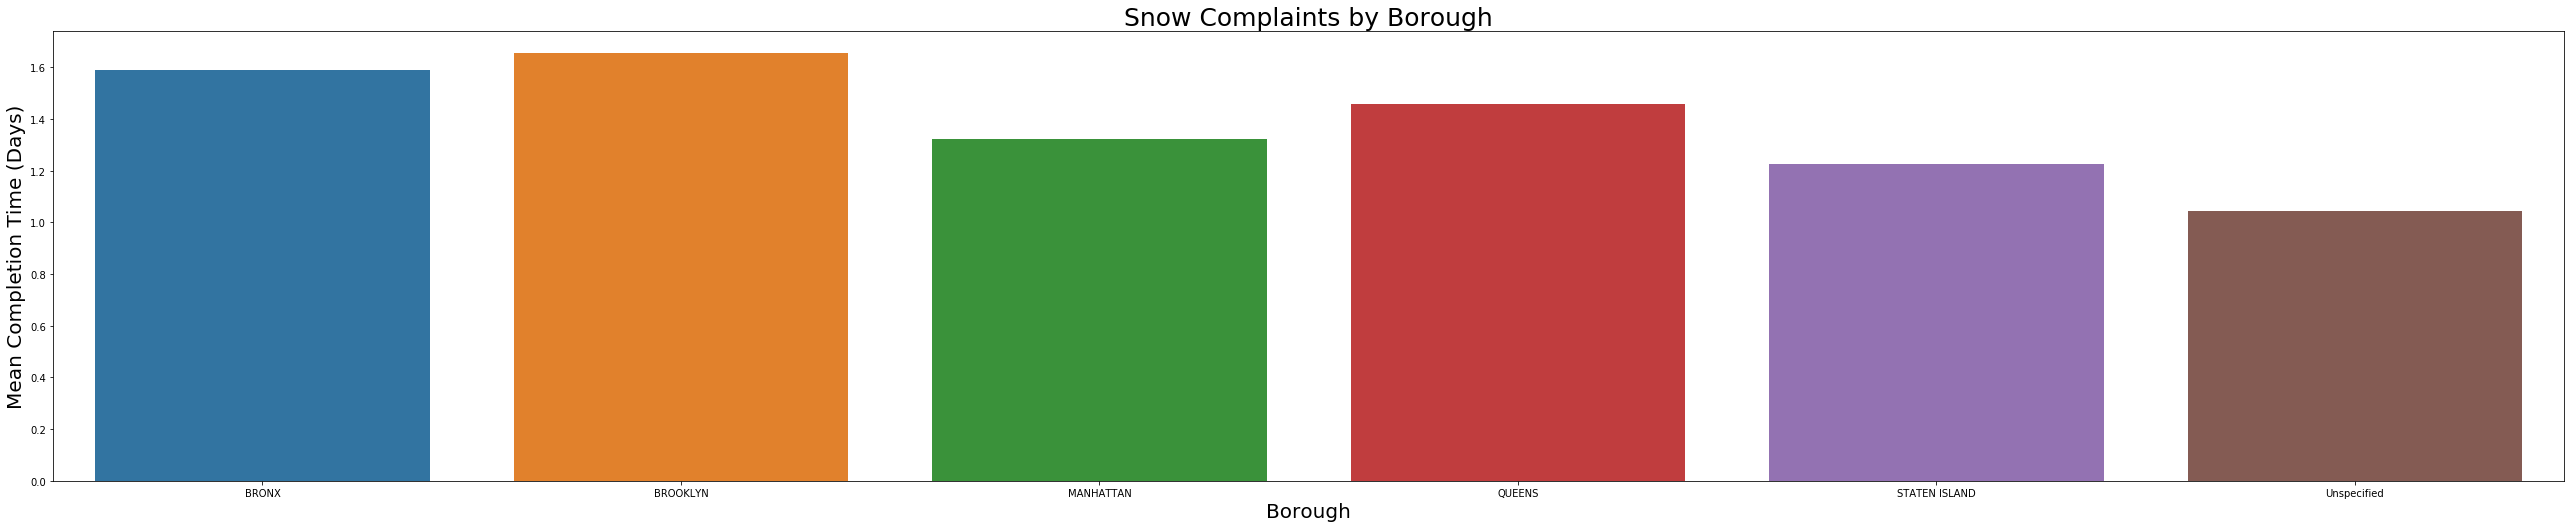

In [187]:
#snow complaints by borough


x= 'borough'
y= 'mean'



ax = sns.barplot(x, y, data=snow_borough)
ax.set_title('Snow Complaints by Borough', fontsize=25)
ax.set_xlabel("Borough",fontsize=20)
ax.set_ylabel("Mean Completion Time (Days)",fontsize=20)
plt.gcf().set_size_inches(45, 8.27)
plt.show()

min days:  0.0 
 max days:  131.93 
 mean:  2.2 
 median:  1.93 
 iqr:  1.84 
 % unobserved:  0.15


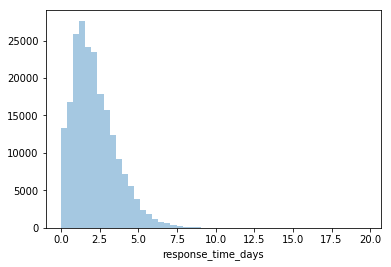

In [188]:
# HPD Heat and Hot Water Complaints – response window? What percentage are unobserved?

heat_water =  db[db['complaint_type']== 'HEAT/HOT WATER']
heat_water = heat_water[heat_water.response_time_days >0]
print(
    'min days: ',round(heat_water.response_time_days.min(),2),'\n',
    'max days: ',round(heat_water.response_time_days.max(),2),'\n',
    'mean: ',round(heat_water.response_time_days.mean(),2),'\n',
    'median: ',round(heat_water.response_time_days.median(),2),'\n',
    'iqr: ',round(iqr(heat_water.response_time_days),2),'\n',
    '% unobserved: ', round(len(heat_water[heat_water.res_desc == 'did_not_observe'])/len(heat_water),2)
)

sns.distplot(heat_water[heat_water.response_time_days<20].response_time_days, kde=False)

In [189]:
# HPD What types of complaints are consistently (if any) going unobserved?

df_hpd = db[db.agency =='HPD']
grouped_hpd = df_hpd.groupby(['complaint_type','res_desc'])
grouped_hpd = grouped_hpd.agency.aggregate('count').to_frame().reset_index()
grouped_hpd

pivot_hpd = grouped_hpd.pivot_table(index='complaint_type',columns='res_desc',aggfunc=sum)
pivot_hpd.fillna(0,inplace=True)
pivot_hpd.columns = pivot_hpd.columns.droplevel()
pivot_hpd.columns.name = None
pivot_hpd.reset_index(inplace=True)
#pivot_hpd = pivot_hpd.drop(pivot_hpd.columns[[7,8,9]], axis=1)
pivot_hpd['total'] = pivot_hpd.sum(axis=1)
pivot_hpd['unobserved_rate'] = round(pivot_hpd.did_not_observe/pivot_hpd.total,2)
pivot_hpd = pivot_hpd.sort_values(by= 'unobserved_rate', ascending = False)
pivot_hpd.to_csv('hpd_unobserved_rate.csv')

In [190]:
# HPD Lead Complaints – response window? Resolution?
tmp = db[(db.agency == "HPD")&(db.descriptor.str.contains('Lead')==True)]
tmp.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,address_type,city,landmark,facility_type,status,due_date,resolution_description,resolution_action_updated_date,community_board,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location,response_time,response_time_days,response_time_hours,response_time_minutes,response_time_seconds,under_120,res_desc
22765,41338428,2019-01-04 09:39:30,2019-01-07 11:20:27,HPD,Department of Housing Preservation and Develop...,HPD Literature Request,New Lead Law Rights and Requirements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed,2019-01-14T11:20:10.000,the literature has been mailed. if it has not ...,2019-01-07T11:20:27.000,0 Unspecified,NaN,Unspecified,NaN,NaN,PHONE,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3 days 01:40:57,3.070104,73.682500,4420.950000,265257.0,0,fixed
53620,41374715,2019-01-08 17:06:09,2019-01-09 17:07:55,HPD,Department of Housing Preservation and Develop...,HPD Literature Request,New Lead Law Rights and Requirements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed,2019-01-09T17:06:09.000,the literature will be emailed within 24 hours...,2019-01-08T17:08:39.000,0 Unspecified,NaN,Unspecified,NaN,NaN,PHONE,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 days 00:01:46,1.001227,24.029444,1441.766667,86506.0,0,ongoing
188031,41514457,2019-01-25 14:21:45,2019-01-26 14:25:14,HPD,Department of Housing Preservation and Develop...,HPD Literature Request,New Lead Law Rights and Requirements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed,2019-01-26T14:21:45.000,the literature will be emailed within 24 hours...,2019-01-25T14:24:45.000,0 Unspecified,NaN,Unspecified,NaN,NaN,PHONE,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 days 00:03:29,1.002419,24.058056,1443.483333,86609.0,0,ongoing
437596,41842733,2019-02-28 09:56:25,2019-03-01 09:59:43,HPD,Department of Housing Preservation and Develop...,HPD Literature Request,New Lead Law Rights and Requirements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed,2019-03-01T09:56:25.000,the literature will be emailed within 24 hours...,2019-02-28T09:59:49.000,0 Unspecified,NaN,Unspecified,NaN,NaN,PHONE,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 days 00:03:18,1.002292,24.055000,1443.300000,86598.0,0,ongoing
464699,41866507,2019-03-04 13:49:27,2019-03-05 13:03:58,HPD,Department of Housing Preservation and Develop...,HPD Literature Request,New Lead Law Rights and Requirements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed,2019-03-12T13:03:54.000,the literature has been mailed. if it has not ...,2019-03-05T13:03:58.000,0 Unspecified,NaN,Unspecified,NaN,NaN,PHONE,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 23:14:31,0.968414,23.241944,1394.516667,83671.0,0,fixed


In [191]:
# DEP Lead Kit Request – response window? Resolutions? Follow-up with Kit results?

lead.res_desc.value_counts()

fixed              8713
did_not_observe       2
Name: res_desc, dtype: int64

In [192]:
# DOT Pothole Complaints – response window? Resolution? How many pothole complaints get sent to DEP (can we assume these are in fact sinkholes)? What is the DEP Resolution?

db[db['complaint_type'] =='Street Condition']['descriptor'].value_counts()

db[db.descriptor == 'Pothole']['resolution_description'].value_counts()

print(
    'min days: ',round(db[db.descriptor == 'Pothole'].response_time_days.min(),2),'\n',
    'max days: ',round(db[db.descriptor == 'Pothole'].response_time_days.max(),2),'\n',
    'mean: ',round(db[db.descriptor == 'Pothole'].response_time_days.mean(),2),'\n',
    'median: ',round(db[db.descriptor == 'Pothole'].response_time_days.median(),2),'\n',
    'iqr: ',round(iqr(db[db.descriptor == 'Pothole'].response_time_days),2),'\n',
    '% unobserved: ', round((len(db[(db.descriptor == 'Pothole')&(db.res_desc == 'did_not_observe')])*100)/len(db[db.descriptor == 'Pothole']),2)
)

min days:  -1.51 
 max days:  286.96 
 mean:  2.69 
 median:  1.1 
 iqr:  2.19 
 % unobserved:  10.51


In [193]:
#calculate how much of a the data set is covered by the classification system
db.res_desc.value_counts()

len(db[(db.res_desc != 'string')])/len(db)

0.9950501038541033

In [194]:
# NYPD Noise Complaints by Borough and Community Board

noise_nypd = db[(db.agency == "NYPD")&(db['complaint_type'].str.contains('Noise'))]
noise_board = noise_nypd.groupby('community_board')
noise_board = noise_board.response_time_hours.aggregate(['count', 'mean', 'std']).reset_index()
noise_boro = noise_nypd.groupby('borough')
noise_boro = noise_boro.response_time_hours.aggregate(['count', 'mean', 'std']).reset_index()


noise_board = noise_board[~noise_board['community_board'].str.contains("Unspecified")]
noise_boro = noise_boro[~noise_boro['borough'].str.contains("Unspecified")]


noise_board['community_board'] = [reverseWords(x) for x in noise_board['community_board']]
noise_board=noise_board.sort_values(by='community_board')

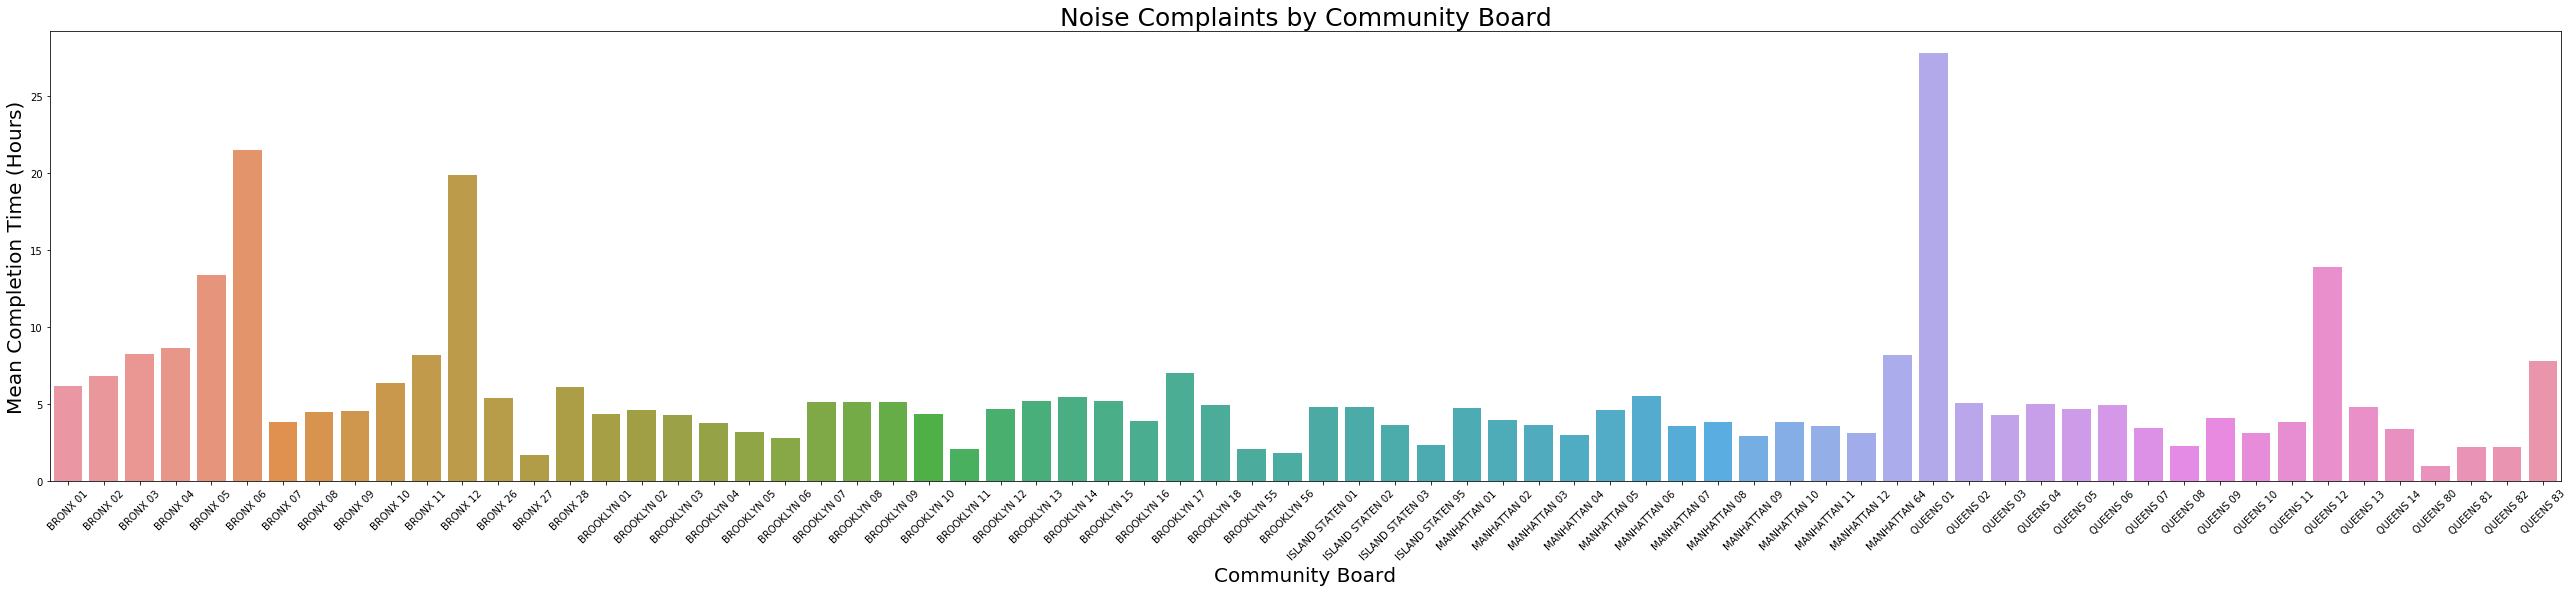

In [195]:
x= 'community_board'
y= 'mean'



ax = sns.barplot(x, y, data=noise_board)
ax.set_title('Noise Complaints by Community Board', fontsize=25)
ax.set_xlabel("Community Board",fontsize=20)
ax.set_ylabel("Mean Completion Time (Hours)",fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.gcf().set_size_inches(45, 8.27)
plt.show()

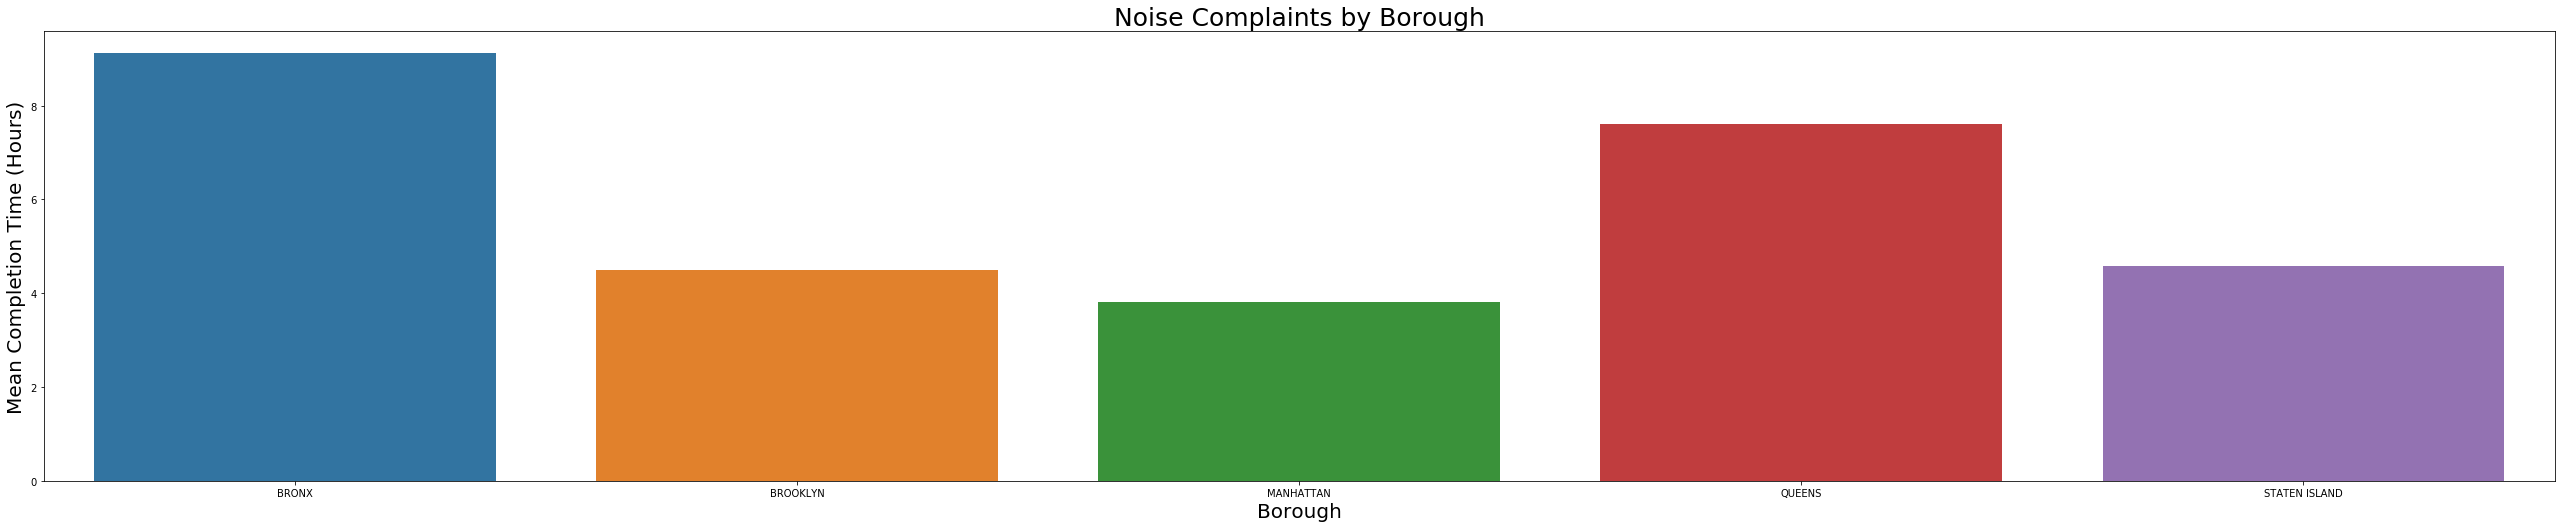

In [196]:
x= 'borough'
y= 'mean'



ax = sns.barplot(x, y, data=noise_boro)
ax.set_title('Noise Complaints by Borough', fontsize=25)
ax.set_xlabel("Borough",fontsize=20)
ax.set_ylabel("Mean Completion Time (Hours)",fontsize=20)
plt.gcf().set_size_inches(45, 8.27)
plt.show()

In [197]:
#median, mean and iqr response times for 04 Bronx in hours
print(
    noise_nypd[noise_nypd['community_board'] == "04 BRONX"].response_time_hours.median(),
    noise_nypd[noise_nypd['community_board'] == "04 BRONX"].response_time_hours.mean(),
    iqr(noise_nypd[noise_nypd['community_board'] == "04 BRONX"].response_time_hours)
)

4.134166666666666 8.61358263639979 9.67


In [200]:
top_complaints_19 = db.complaint_type.value_counts().rename_axis('Complaint').reset_index(name='Count')

In [202]:
top_complaints_19.to_csv("top_complaints_19.csv")